## Exploration with Word Embedings (Deep Learning)
   
### CBOW
#### Model p(word | context)
#### Advantages: Smoots over distribution by averaging over all context words. This is helpful for small training sets.
####                        Also faster
   
<img src="./images/CBOW.png" width="300"> 

### Skipgram 
#### Model p(context | word) 
#### Advantage: Learns finer-grained vectors on large training data (i.e. better with infrequent words)

<tr>
    <td><img src="./images/Skip-Gram.png" alt="Drawing" style="width: 300px;"/></td>
    <td><img src="./images/skip_gram_net_arch.png" alt="Drawing" style="width: 500px;"/></td>
</tr>
    

## Environment Setup

#### First we will import some Python packages that we will use.

In [1]:
import re
import time
import numpy as np
import pandas as pd
import pickle as pkl
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from gensim.models import Phrases
import sklearn
from sklearn.manifold import TSNE
%matplotlib inline 
import matplotlib.pyplot as plt

#from string import punctuation
#from sklearn.cluster import KMeans
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics.pairwise import cosine_similarity
#from sklearn.manifold import MDS
#from gensim.models import Doc2Vec
#from gensim.models.doc2vec import LabeledSentence


## More Environment Setup

#### We also need to load some nltk resources. These resources will help us clean the data.

In [2]:
# Text contains a lot of noisy words that are simply there to help with fluency.
nltk.download("stopwords")

# PUNKT is a tokenizer so that we can work with words and identify sentence boundaries.
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jpferraro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jpferraro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Syntactic NLP Processing

#### We want to coustomize tokenization so we have more control over our text and can remove unique textual forms of noise like dates, ages, etc.

In [3]:
def tokenize(text):
    sentence_list = [[sentence] for sentence in nltk.sent_tokenize(text)]
    tokenized_sentence_list = [nltk.word_tokenize(tokens) for sentence in sentence_list for tokens in sentence]
    filtered_sentence_list = []
    for tokenized_sentence in tokenized_sentence_list:
        filtered_sentence = []
        for token in tokenized_sentence:
            if (re.search('(^[a-zA-Z]+$)', token)):
                filtered_sentence.append(token)
        if filtered_sentence:
            filtered_sentence_list.append(filtered_sentence)        
    return filtered_sentence_list

## Retrieving our Corpus

#### Let's pull in our corpus that we had serialized out to disk.

In [4]:
file = open('differential-corpus.pkl','rb')
corpus = pkl.load(file)
file.close()

## Data Structure Transformation

#### Let's build a dataframe so we can select case types easily.

In [5]:
df = pd.DataFrame(columns=('case', 'document', 'label'))
for case, document in corpus.items():
    if 'PNA' in case:
        df = df.append({'case': case, 'document': document, 'label': 'PNA'}, ignore_index=True)
    elif 'COPD' in case:
        df = df.append({'case': case, 'document': document, 'label': 'COPD'}, ignore_index=True)
    else: # CHF
        df = df.append({'case': case, 'document': document, 'label': 'CHF'}, ignore_index=True)       

## Building our Corpus

#### Using a data frame makes it easy to select between different cohorts.

In [6]:
df_pna = df.loc[df['label'] == 'PNA']

pneumonia_corpus = []
for index, row in df_pna.iterrows():
        document = row['document']
        document_sentences = tokenize(document)
        pneumonia_corpus.extend(document_sentences)
print(pneumonia_corpus)

[['DATE', 'AM', 'CT', 'CHEST', 'CONTRAST', 'Clip', 'Number', 'Radiology', 'Reason', 'please', 'eval', 'for', 'loculated', 'pleural', 'effusion', 'on', 'the', 'right', 'and', 'Field', 'of', 'view', 'UNDERLYING', 'MEDICAL', 'CONDITION', 'year', 'old', 'woman', 'with', 'RUL', 'subtotal', 'resection', 'for', 'lung', 'CA', 'as', 'well', 'as', 'a', 'LLL', 'superior', 'segment', 'resection', 'for', 'Tb', 'and', 'now', 'presents', 'a', 'RLL', 'PNA', 'and', 'parapneumonic', 'effusion', 'concerning', 'for', 'empyema', 'REASON', 'FOR', 'THIS', 'EXAMINATION', 'please', 'eval', 'for', 'loculated', 'pleural', 'effusion', 'on', 'the', 'right', 'and', 'place', 'a', 'pigtail', 'catheter', 'send', 'specimen', 'for', 'Gm', 'stain', 'AFB', 'smear', 'cytology', 'Fungal', 'culture', 'please', 'do', 'ASAP', 'as', 'pt', 'may', 'require', 'to', 'go', 'to', 'the', 'OR', 'later', 'this', 'afternoon', 'FINAL', 'REPORT', 'INDICATION', 'PREVIOUS', 'HISTORY', 'OF', 'SUBTOTAL', 'RESECTION', 'FOR', 'LUNG', 'CANCER', '

In [8]:
from gensim.models.phrases import Phraser

pneumonia_bigram_transformer = Phrases(pneumonia_corpus, min_count=20, threshold=5)
#pneumonia_bigram_transformer = Phraser(pneumonia_corpus, min_count=20, threshold=5)

pneumonia_bigram_corpus = []
for sentence in pneumonia_corpus:
    pneumonia_bigram_corpus.append(pneumonia_bigram_transformer[sentence])


TypeError: __init__() got an unexpected keyword argument 'min_count'

## Train a Word2Vec Model

#### Some hyperparameters that we can tune are:
####  - sg = 0 (CBOW) | 1 (Skip-Gram) 


In [129]:
%time pneumonia_model = Word2Vec(pneumonia_corpus, sg = 1, size = 300, window = 7, min_count = 5, workers = 5)

%time pneumonia_bigram_model = Word2Vec(pneumonia_bigram_corpus, sg = 1, size = 300, window = 7, min_count = 5, workers = 5)

CPU times: user 31.9 s, sys: 8 ms, total: 31.9 s
Wall time: 6.71 s
CPU times: user 26.8 s, sys: 24 ms, total: 26.8 s
Wall time: 5.75 s


## What does a Word2Vec model look like?

#### Vocabulary Size
#### Neurel Network Embedding Size
#### Learning Rate

In [130]:
print(pneumonia_model)

print(pneumonia_bigram_model)

Word2Vec(vocab=1808, size=300, alpha=0.025)
Word2Vec(vocab=2001, size=300, alpha=0.025)


## Accessing Word2Vec's Dictionary

#### Let's look at the Word2Vec dictionary by individual term and as a whole . . . 


In [131]:
print("* * * * * Term vector for inflitrate\n")
print(pneumonia_model.wv['infiltrate'], "\n\n")

print("* * * * * Dictionary of term vectors\n")
w2v = dict(zip(pneumonia_model.wv.index2word, pneumonia_model.wv.syn0))
for keys,values in w2v.items():
    print(keys)
    print(values)

* * * * * Term vector for inflitrate

[-0.12208232  0.11308431 -0.20503476  0.31562892  0.01099477  0.12263006
 -0.19371268 -0.01308619  0.06057301  0.07894643 -0.14867517 -0.08716645
  0.07104371  0.01545366 -0.04492551 -0.07378459  0.04740161  0.01594776
 -0.19669023  0.04419774 -0.0170257  -0.03982753 -0.11456152  0.00544873
 -0.09147924  0.1649494   0.03829465 -0.03908271 -0.00849074  0.06217049
  0.12170256 -0.06725876 -0.22868729  0.10398511 -0.00504465  0.01233136
  0.19904545  0.0079467   0.07842918  0.16918419  0.05978447 -0.02057968
 -0.23646854  0.15625273  0.03636111  0.00846291  0.07177734  0.08146291
  0.15427953  0.14489162  0.06789968  0.16707893 -0.10116058 -0.00068636
  0.00146535  0.09402794  0.1071684  -0.02799917 -0.23408258 -0.21664716
 -0.20463213  0.08428793  0.1310741   0.00183809 -0.23662363  0.07312655
 -0.00210216 -0.16834781  0.01830149  0.06857331  0.09637452 -0.01598828
 -0.12664035  0.17416507  0.0206481   0.02556827 -0.36276042 -0.25202361
  0.40934676 

represents
[-0.00397613  0.16583748  0.01290691  0.05272118 -0.0331871  -0.04434779
 -0.18806779  0.20748045 -0.03050298 -0.03126071 -0.08225906 -0.2873717
 -0.00382883  0.04276826  0.04611054 -0.05969442 -0.05537549 -0.09501437
  0.01930954 -0.03178544 -0.16156128  0.16868292 -0.27751011 -0.19298735
 -0.00897132 -0.07045561  0.21755695  0.00527367 -0.09762813  0.0476453
 -0.04885907 -0.01153955 -0.00651171  0.08355001 -0.05535386  0.09034719
  0.01594448 -0.23563017  0.09444613  0.05891268 -0.01757243 -0.08101598
 -0.13003345  0.07669993 -0.02003692 -0.01182627 -0.01066729 -0.12505843
 -0.04002581  0.13584132  0.10775183  0.19302619 -0.18236403  0.02252918
 -0.10084646  0.12706901 -0.05882148  0.08944634  0.01799104 -0.00595633
  0.03760135  0.15426718  0.13812266 -0.11666952 -0.08068801  0.24311952
  0.15898564 -0.11988772  0.04747554 -0.05757878  0.19471064 -0.12083757
 -0.06649134 -0.07113184 -0.06810977  0.13098758 -0.16916345 -0.21402846
  0.18491727 -0.00340945 -0.30162808 -0.11

[-0.01399312  0.0873153  -0.0094898   0.05128007 -0.01798648 -0.0236599
 -0.06641071  0.05484733  0.00138154 -0.07673001 -0.07158618 -0.182941
 -0.03275602  0.04222867  0.01147982  0.0258713  -0.02639812 -0.05732722
  0.0930877  -0.03992141 -0.15884206  0.14574619 -0.19564976 -0.17682324
  0.00416306 -0.00892397  0.10589514 -0.00446868 -0.02043617  0.03333952
  0.01136666 -0.03798633 -0.0009353   0.07444636 -0.01913239  0.08167763
  0.03097975 -0.12247936  0.09094625  0.04817569 -0.07224357 -0.14591706
 -0.17264654  0.04143156  0.01034168  0.04309237  0.01518776 -0.08424101
 -0.01525322  0.10258595  0.06891304  0.10018343 -0.15026334 -0.01386215
 -0.15905258  0.09699409 -0.03231203  0.02337536 -0.02316323 -0.06583966
 -0.01442369  0.12229594  0.08503188 -0.0393219  -0.04710077  0.15874819
  0.08351129 -0.14979091  0.08286575 -0.01176838  0.15823057 -0.00682971
 -0.01195214 -0.01871375  0.02635838  0.09131493 -0.13857967 -0.19160685
  0.14976069 -0.00920127 -0.26932263 -0.10060617  0.18

  0.1451171  -0.08000708  0.00238174  0.07690857 -0.21502605  0.14091355]
middle
[-0.19359717 -0.03881576 -0.13258903  0.19844446  0.05992358 -0.07959042
 -0.04467497  0.28165051 -0.0135107  -0.07094854 -0.19764139 -0.18448474
 -0.00848979 -0.1761878   0.0202716   0.11544172 -0.1146742   0.00340416
 -0.00481003 -0.16333969 -0.05723733  0.03564227 -0.34204265 -0.12691478
 -0.10053784  0.30974692  0.05744352  0.18491152 -0.06276505  0.09791371
  0.11320133 -0.10188203 -0.16169983  0.17322363  0.05399676  0.14298661
  0.18357764 -0.0145509   0.25006554  0.34485582 -0.12672494  0.00730936
 -0.27501935 -0.11572472  0.12637921  0.22870149 -0.18927379  0.04729941
 -0.08919441  0.23242953  0.39202359  0.12560637 -0.32511449  0.05217656
 -0.05695445  0.02307435  0.02221172  0.10106806 -0.01383595 -0.06418344
 -0.18119553  0.153558   -0.02349323  0.20857614 -0.27183729  0.30945083
  0.03065066 -0.07581398  0.22516328  0.02093432  0.1517572   0.24203017
  0.01277754  0.01843651 -0.00046611  0.067

[ 0.0103754  -0.0057017  -0.14206515  0.2123491   0.02560387 -0.02781004
  0.03758498 -0.23274238 -0.05576759 -0.19801484  0.03984775 -0.20242439
  0.01744312  0.08559904  0.04080642  0.21485178 -0.02154974  0.00086256
  0.3148402   0.12233523 -0.40516755  0.20998283 -0.2319553  -0.21262871
  0.07698892 -0.02412044 -0.01743706 -0.01027327  0.10424297  0.06965676
  0.15525758 -0.14949687  0.0172118   0.02958523 -0.02832348  0.03317118
 -0.0653438  -0.01775226  0.20206231 -0.02010261 -0.20844944 -0.1454972
 -0.27201766  0.07893203  0.09965438  0.0046845   0.07981119 -0.15551798
 -0.01129702  0.05985711 -0.06647682 -0.0157456  -0.1371835   0.00727079
 -0.35941544  0.13906716 -0.0703993  -0.06494682 -0.08847003  0.01012219
 -0.16784804  0.18861513  0.07992723  0.07958941  0.04130227  0.12667125
 -0.03460601 -0.32977632  0.2717298   0.14198476  0.32250467  0.07016223
 -0.07041895  0.09665247  0.33638155 -0.07887788 -0.25231141 -0.14657122
  0.06326022  0.04360208 -0.24741569 -0.14803515 -0.

[ 0.14507671  0.05392861 -0.2253831   0.25230917 -0.00790195 -0.02840512
 -0.17767888 -0.10813053 -0.07020348 -0.0520335  -0.07473534 -0.23500064
  0.1030126   0.12909935  0.06956406  0.09166127  0.10138754 -0.04424659
  0.20899041 -0.01593617 -0.35457355  0.16412672 -0.28985563 -0.31513506
 -0.00761544 -0.05175401 -0.0632956   0.0867932  -0.05080111  0.02918621
  0.08003228 -0.08583219  0.01477521 -0.02665111 -0.10504965  0.00421577
 -0.15241708 -0.09020449  0.10958036 -0.12761478 -0.07428207 -0.15584999
 -0.29627892  0.09352119  0.09232686  0.02111278 -0.05862014 -0.2196281
 -0.06304508  0.03560286 -0.20372796 -0.01526207 -0.23309168  0.02699406
 -0.1546998   0.13980645 -0.04038423 -0.04487635 -0.04089308 -0.00855459
 -0.00215561  0.26422015  0.07075414 -0.07714633  0.06904463  0.27600616
  0.0736407  -0.15557393  0.25352749  0.12728877  0.21483654 -0.21198116
 -0.10002743  0.13731879  0.14485751  0.04139892 -0.22029805 -0.17288283
 -0.03300254  0.10789748 -0.13218334 -0.00961856  0.

[-0.01484587  0.05185248  0.00121382  0.05485698  0.01905227 -0.05947657
 -0.07247499  0.0623076  -0.02994705 -0.06807583 -0.01944217 -0.17911808
  0.01044456 -0.02415496  0.02354303  0.01610751  0.0214872  -0.01862861
  0.09767446 -0.09805851 -0.0816813   0.04494951 -0.12123313 -0.08159484
  0.01714493  0.03295499  0.04440036  0.04852061 -0.05797528 -0.02601693
  0.01080089 -0.06533977  0.04659859  0.03115863 -0.01980317  0.09074876
 -0.024781   -0.04468287  0.1292695   0.06050415 -0.10904039 -0.09777121
 -0.12029011 -0.00197424  0.03520947  0.02533537 -0.05528892 -0.04668806
 -0.07396219  0.10682455  0.09286893  0.11366969 -0.18643168  0.01203031
 -0.1022528   0.02718473 -0.07146624  0.03243733 -0.0131713  -0.02636488
  0.0389608   0.13181505  0.03641037 -0.03429519 -0.07589779  0.17050825
  0.07691032 -0.07540223  0.08960568  0.0529088   0.07308426  0.06604791
 -0.01728468  0.03007983 -0.00491064  0.08396534 -0.09424885 -0.15089948
  0.05616578 -0.01306495 -0.15844338 -0.04310608  0

FRACTUR
[-0.09432755  0.21438634 -0.08763243  0.31744844  0.05459942  0.04293606
 -0.21159273 -0.11983677  0.17736991 -0.1256717   0.01265781 -0.16353333
  0.00690355  0.16373603  0.22362338  0.07887478 -0.03248314 -0.10952914
 -0.03630304  0.08753634 -0.16305842 -0.09979164 -0.02574049  0.1814405
  0.12299465  0.13033232 -0.04485045  0.01771721 -0.00783689  0.09885119
  0.2120502  -0.21259061 -0.19691199  0.13031398  0.02835817  0.04136819
  0.10990489  0.15858652  0.31422591  0.3309879  -0.13130727 -0.08555967
 -0.15461563  0.2612496   0.04162996 -0.11583848  0.30536786  0.16385803
  0.11337011  0.25231332  0.21678275  0.19019805 -0.06995108  0.15797015
 -0.53059107 -0.00938128  0.10609593 -0.0606848  -0.12021884 -0.1635315
 -0.28845796  0.10941882  0.09561441  0.06391094 -0.34781554 -0.0725693
 -0.09509834 -0.29593629 -0.20076653  0.2106915   0.20693718  0.06496663
 -0.20272091  0.22277325  0.26746094 -0.07318197 -0.34047529 -0.12339833
  0.28830951 -0.22162859 -0.38637471 -0.088678

year
[-0.07723758  0.18613794 -0.00298839  0.17862967  0.04525955 -0.05639324
 -0.17360833 -0.00237506 -0.00428118 -0.13886259  0.08581223 -0.15164952
  0.17458448  0.07737909  0.24713834 -0.06032342 -0.27497151 -0.25049651
  0.02139935  0.03129863 -0.22743699 -0.05747685 -0.00633597  0.22935995
  0.02743525  0.21789385  0.04591492 -0.09217774  0.11086898  0.12437414
  0.11053527 -0.18195888 -0.09668794  0.17817928  0.04317197 -0.02064842
 -0.04199876  0.19249278  0.31592509  0.37516186 -0.13742398  0.03762979
 -0.02968462  0.32675403  0.07191367 -0.07914364  0.37264195  0.24938127
  0.10358569  0.28927377  0.27538353  0.19786577 -0.11501557  0.28391075
 -0.52746767  0.13453744 -0.05158968  0.00813951 -0.19102485 -0.10114478
 -0.20126778  0.22385156  0.28626329  0.14758117 -0.24646077 -0.13786402
 -0.01321739 -0.07262587 -0.25867727  0.28576946  0.22284071  0.06455314
 -0.15639295  0.27441737  0.21207206 -0.12546551 -0.35004774 -0.08415014
  0.23091292 -0.26349115 -0.34794083 -0.051236

[-0.04932145  0.03865586 -0.01903784  0.10997806  0.04060714 -0.01966201
 -0.04412753 -0.03230255  0.01503699 -0.04484348  0.01529418 -0.07354075
  0.01240947  0.05515278  0.02628035 -0.01471286 -0.06034626 -0.06697039
  0.02397025 -0.00910207 -0.09166177 -0.02489509 -0.04481209  0.03554691
  0.00332564  0.0723397   0.00088788 -0.01112588  0.00591976  0.051901
  0.0666279  -0.07875118 -0.07745523  0.06795251  0.00492708  0.00520756
  0.01320277  0.0694624   0.15268438  0.11277777 -0.05355845 -0.0413985
 -0.05093848  0.09662369  0.04033858 -0.02678653  0.08344441  0.05662563
  0.02743489  0.12144913  0.07377768  0.0872876  -0.08103092  0.10291713
 -0.18989632  0.01648952 -0.02362416 -0.04327456 -0.06933823 -0.07551016
 -0.08967484  0.11222993  0.07103714  0.03709659 -0.1006694  -0.00592648
 -0.01513978 -0.10206164 -0.01256494  0.06182017  0.11319266  0.06875683
 -0.06211517  0.08346295  0.07602592 -0.02770129 -0.17826343 -0.06641963
  0.12833509 -0.09518597 -0.1625068  -0.02976562  0.01

rhonchi
[-0.09476487  0.07873192 -0.0076509   0.14186417  0.05738283 -0.00964344
 -0.05461297  0.02361574  0.00823109 -0.06736956 -0.04268605 -0.07292844
  0.02752236  0.07371616  0.05524534 -0.04627161 -0.10521828 -0.08275845
 -0.02145851 -0.04126379 -0.13375863 -0.04501234 -0.05432201  0.01394998
 -0.01660778  0.10898834  0.05478859 -0.0689586  -0.0164198   0.07673995
  0.08591186 -0.06155132 -0.14291263  0.15428969  0.00134448  0.0004208
  0.06439611  0.0609541   0.11896431  0.15867257 -0.02181141 -0.05607422
 -0.07560837  0.12590855  0.04160019  0.00759546  0.13601755  0.07390178
  0.09666987  0.12822004  0.10562198  0.14941913 -0.1070767   0.16090643
 -0.21073928  0.06751221 -0.02281319 -0.03907644 -0.0964355  -0.1233511
 -0.08987444  0.13730006  0.13338473  0.02415198 -0.11948852 -0.01134375
 -0.00663049 -0.09485158 -0.07739384  0.09569837  0.12657434  0.05736867
 -0.08067961  0.09995563  0.0490978   0.04001423 -0.26432249 -0.12210191
  0.22987458 -0.17518398 -0.23788813 -0.00946

neck
[-0.02596031  0.05675947  0.00809163  0.0240348   0.01675517 -0.04513219
 -0.03515675  0.00729354 -0.04822925 -0.09119049 -0.01593816 -0.13527188
 -0.01080638 -0.05652672 -0.00283435  0.01076064  0.03469711  0.00000604
  0.08829065 -0.16060753 -0.05247308 -0.025617   -0.0473335  -0.06051045
 -0.02904766  0.06410345 -0.04416245  0.03075636 -0.07208338 -0.01992837
  0.02753831 -0.09075256  0.05093045  0.04379462 -0.03887955  0.06408685
 -0.057563    0.09203358  0.12740909 -0.02047873 -0.10404648 -0.15530233
 -0.08896569  0.05204736  0.08973921 -0.01203364 -0.04509307 -0.02973442
 -0.07650398  0.14062643  0.04808917  0.07793126 -0.24645488  0.08323256
 -0.13888659  0.01192    -0.08608092 -0.08460446 -0.04630585 -0.10457174
  0.07066272  0.16621178  0.01146187 -0.06251162 -0.02617174  0.10953129
  0.08586225 -0.03156275  0.04600425  0.00298825  0.03237898  0.07401712
 -0.03362483  0.08430894 -0.04419284  0.08073015 -0.11672424 -0.13759367
  0.07076846 -0.02765333 -0.17677672  0.053831

apparent
[-0.03506563  0.0700908  -0.11425311  0.16724688  0.01312457  0.00731013
 -0.17348687  0.08179623 -0.0222203  -0.02842523 -0.03968929 -0.11577535
  0.0640485   0.00846185  0.02815533 -0.00477708  0.0252863  -0.04400348
  0.01136718 -0.077913   -0.11444639 -0.000344   -0.13986832 -0.07351369
 -0.01416984  0.08088762 -0.00435492  0.06188206 -0.08082356  0.01184665
  0.07586687 -0.08770008 -0.04957633  0.02439473 -0.01972414  0.01724374
 -0.00156341  0.0087322   0.12715995  0.07508651 -0.0606369  -0.03927351
 -0.14403397  0.07156387  0.09511217  0.02201557 -0.00016466 -0.0070236
 -0.05537421  0.09811644  0.06683768  0.10545426 -0.1860245   0.09154801
 -0.08218645  0.00693917 -0.02226192 -0.00383885 -0.03854948 -0.02342371
 -0.05648446  0.12314039  0.03502825 -0.0379469  -0.09906484  0.15290368
  0.03140162 -0.06408068  0.04364833  0.07574559  0.06987662 -0.01704795
 -0.08660576  0.08361994  0.05339999  0.01193437 -0.11448328 -0.10764321
  0.08600554 -0.00636434 -0.10978418 -0.003

[-0.02782198  0.09969699  0.0064764   0.09058738 -0.05696287  0.02894122
 -0.05697504  0.03107729 -0.00669182 -0.05050781 -0.12116672 -0.20031558
 -0.03530996  0.0648841  -0.02010852  0.05057991  0.0220986  -0.00412501
  0.08878544 -0.02664652 -0.22690734  0.1439873  -0.26715317 -0.2342547
  0.00551324 -0.05449608  0.14813472 -0.03289877 -0.02274384  0.00953206
  0.03396466 -0.03988698  0.01055669  0.14583567 -0.04885352  0.07568032
  0.05453303 -0.18329678  0.04582037  0.03308493 -0.0247766  -0.15105335
 -0.22273828  0.03365294 -0.00555243  0.0337314   0.00931309 -0.1409677
  0.03548079  0.11520496  0.03448351  0.12854552 -0.15126471 -0.03751735
 -0.09231558  0.1618508  -0.00318419  0.02706536 -0.00962099 -0.0737727
 -0.00621009  0.10874622  0.10626685 -0.06499711 -0.08463325  0.20449425
  0.08265369 -0.19240271  0.08188409 -0.02287385  0.15966105 -0.06084994
 -0.05435095 -0.03050611 -0.00912923  0.1039281  -0.18281105 -0.2013465
  0.22902921 -0.01678468 -0.31785852 -0.15714762  0.213

[-0.01359142  0.14365344 -0.07780766  0.23638898  0.08651438  0.08858967
 -0.16223942 -0.09064612 -0.12041637  0.00190069 -0.04394231 -0.08639333
  0.08409261  0.09658585  0.08681335  0.02237392 -0.07118639 -0.00835349
 -0.12944154  0.11161056 -0.13526292  0.00241511 -0.02687298  0.01587016
 -0.04358365  0.05465863  0.08900253 -0.09367771  0.01862976  0.12328817
  0.00880933 -0.12499582 -0.17534076  0.19245683 -0.03357837 -0.01393399
  0.05612029 -0.06467175  0.09419054  0.16597608  0.02420335  0.04306062
 -0.09538082  0.09672213 -0.01321023 -0.02235559  0.0704564   0.02678687
  0.2587184   0.06378161  0.02251956  0.23047186 -0.00897416  0.14245878
 -0.16383713  0.19368643  0.06722544 -0.01213685 -0.14024323 -0.18542218
 -0.10585483  0.12394694  0.26047027  0.02427172 -0.14322537 -0.01446937
  0.00422074 -0.13863596 -0.0212378   0.12708762  0.17870237 -0.01615483
 -0.14522572  0.17169549  0.04226512  0.13846606 -0.37394166 -0.23601699
  0.28565773 -0.23822181 -0.27691475 -0.06730565  0

material
[ 0.03456135  0.03088332  0.00658559  0.0972697   0.02807336 -0.07044379
 -0.03744787 -0.06302637 -0.1076874  -0.0606113  -0.02862111 -0.24461269
  0.06749257 -0.05498219 -0.01630152  0.03628452  0.11495755  0.00214842
  0.21486992 -0.15567698 -0.15611449  0.04963036 -0.1907451  -0.16098624
  0.01274162  0.00336058  0.02186998  0.07489    -0.10075663 -0.07010625
  0.01284638 -0.09653296  0.151988   -0.01819818 -0.06561366  0.13242647
 -0.14897977 -0.04571479  0.16508846 -0.02517271 -0.12801473 -0.14181438
 -0.12829758 -0.00452506  0.05361081  0.03953629 -0.10108218 -0.11347175
 -0.12931156  0.13068531 -0.03719512  0.0802485  -0.27104828 -0.02338642
 -0.05908623  0.03746494 -0.12585288  0.0264755  -0.00804583  0.02546679
  0.12876697  0.20827098  0.02630452 -0.05164023 -0.01804659  0.26903751
  0.11840733 -0.05782683  0.18598019  0.10871271  0.07085107  0.05849841
 -0.01432481  0.03035131 -0.03133214  0.07665396 -0.09545653 -0.17031229
 -0.0350284   0.06627294 -0.11324924 -0.02

[ 0.01236744  0.07622958 -0.06300475  0.13721232  0.06647594 -0.05406473
 -0.1112663   0.03784533 -0.03409115 -0.10789867 -0.0431738  -0.1438728
  0.01604373 -0.02677444  0.1365964   0.0608156   0.00438343  0.00760652
  0.06043748 -0.09655322 -0.08120579 -0.0502857  -0.07884622 -0.08257113
 -0.01013855  0.09228226 -0.06852602  0.11268608 -0.11875737  0.02217925
  0.02415091 -0.06321604 -0.00823777  0.0037454  -0.01550406  0.06235597
 -0.05178215  0.05866257  0.12540682  0.03464417 -0.08392822 -0.10220473
 -0.08600194  0.01336938  0.07823706  0.04142835 -0.11012521 -0.0007604
 -0.09351003  0.08242938  0.04776009  0.09881885 -0.22556108  0.12689646
 -0.17342173 -0.02806266 -0.0191935  -0.01409944 -0.03405614 -0.06173742
  0.00961541  0.17355186 -0.03401565 -0.02822535 -0.00204636  0.09883171
  0.03354098 -0.02213074  0.0476766   0.13665396  0.07312966  0.03337535
 -0.07309812  0.1099439   0.03099332  0.08960857 -0.13653243 -0.11187464
  0.03035038 -0.01135601 -0.12830269  0.09826329  0.1

[ 0.00198409  0.05875234  0.1234689  -0.10132777 -0.0876362  -0.02768377
  0.0153616  -0.09153019  0.00160277  0.03791364 -0.07126723 -0.12621665
 -0.07993533  0.0624718  -0.19343507 -0.15743805  0.14076112 -0.08660483
  0.06428227 -0.24603297 -0.03496009 -0.01454701 -0.08160663 -0.16541506
 -0.06291573 -0.05433322  0.06079562 -0.07226659 -0.07105309 -0.04777104
 -0.06883051 -0.06915124  0.07423065  0.08487766 -0.07171711  0.0831909
 -0.04324575  0.02660965  0.09832698 -0.11646281  0.00376102 -0.29658851
 -0.02506013  0.08041307  0.00028594 -0.06195278  0.02931782 -0.0960483
  0.00253702  0.21774146 -0.0888272   0.16226715 -0.23909456  0.02219672
 -0.03341864  0.06193072 -0.0611679  -0.14707595 -0.03217966 -0.20447704
  0.20216291  0.22184321  0.12194431 -0.16433625 -0.01549695  0.10693099
  0.16918191 -0.05073082  0.00409291 -0.11980947  0.00212525 -0.02469705
 -0.02093823 -0.0206051  -0.20645869  0.16814245 -0.17015739 -0.18474698
  0.24693753 -0.03203529 -0.31394419  0.01083441  0.2

situ
[-0.00994347  0.04201001 -0.03605096  0.08896049  0.03798767 -0.03644584
 -0.06976265  0.02702103 -0.0377634  -0.07697774 -0.00190663 -0.13080367
  0.03025622  0.01853359  0.0494683   0.01749014 -0.02812525 -0.04194168
  0.07161581 -0.03722003 -0.10385711  0.03153281 -0.09288121 -0.06057588
  0.00156611  0.0512169   0.01055245  0.03637679 -0.02809467  0.02089284
  0.022104   -0.06505869 -0.02382217  0.03153483 -0.00804934  0.03102961
 -0.03567824 -0.00461881  0.11444655  0.05397749 -0.07081629 -0.05586806
 -0.10257398  0.04134247  0.04271919  0.02265298 -0.01237517 -0.01840492
 -0.02625346  0.07782117  0.05040388  0.08463484 -0.13104105  0.06816328
 -0.14069404  0.03536441 -0.04595457 -0.00921293 -0.03230942 -0.04648404
 -0.02044857  0.13455677  0.04605182 -0.00098039 -0.04059376  0.08408854
  0.03247199 -0.07154451  0.06077062  0.07278816  0.1056945   0.03659321
 -0.04187835  0.06513522  0.04648047  0.03751617 -0.12807104 -0.11552957
  0.05983217 -0.02328859 -0.13134043 -0.007537

[-0.09382266  0.03158225  0.02548104  0.12836501  0.08337671 -0.0578841
  0.05206703 -0.06435014 -0.01463198 -0.04768339 -0.0426428  -0.02918535
  0.00044112  0.04993637  0.04062628 -0.07197514 -0.17235336 -0.10246983
  0.03435301 -0.09091272 -0.20734522 -0.04496567 -0.09162158 -0.02708154
 -0.04300078  0.08810628  0.06154457 -0.12154785  0.01672562  0.16064249
  0.0662319  -0.03414276 -0.12400968  0.19475058  0.00964296  0.0176656
  0.02789522  0.10018293  0.15050212  0.15006223 -0.02738207 -0.10173399
  0.03888222  0.12573989  0.04410967  0.01491509  0.12990616  0.05331314
  0.07284719  0.12590465  0.05159143  0.13331391 -0.13750246  0.22834426
 -0.2417324   0.07556904 -0.05799986 -0.07550549 -0.0861483  -0.12188603
 -0.0798203   0.18656574  0.14405072  0.07690787 -0.04130651 -0.02236083
 -0.01938459 -0.10271285 -0.05648893  0.04754508  0.19641627  0.08505223
 -0.06155321  0.0467864   0.04432772  0.03411682 -0.31886804 -0.09415746
  0.23017883 -0.1883022  -0.2667104   0.01666146  0.1

[-0.13193567  0.01694371  0.050221    0.11862652  0.06550037 -0.09319904
  0.00510894 -0.01891221 -0.00780424 -0.0310269   0.04326167 -0.03811811
  0.10448284  0.11703186  0.02350088 -0.18133636 -0.2222289  -0.21533127
  0.05639507 -0.07135487 -0.21256283 -0.12916777 -0.01235484  0.10178467
 -0.04898803  0.19727446  0.08980837 -0.17010334  0.01884515  0.07354248
  0.1741883  -0.09792945 -0.16280155  0.17253415 -0.01788943 -0.03942322
  0.06198022  0.18021801  0.20894496  0.23410816 -0.06448836 -0.04165855
 -0.05442282  0.22196642  0.0701979  -0.01125251  0.26774013  0.15516947
  0.11871883  0.22102198  0.12282341  0.14047456 -0.12094489  0.234005
 -0.31283274  0.09692578 -0.13123071 -0.07397641 -0.19223958 -0.12445869
 -0.10025413  0.20726988  0.20838362  0.10587743 -0.17510298 -0.09514347
 -0.04317423 -0.09609301 -0.13845265  0.23300168  0.1420968   0.17327946
 -0.12999946  0.13993585  0.10890974 -0.09226551 -0.34985092 -0.05244235
  0.23709998 -0.25559616 -0.20965689 -0.0271609   0.0

liquids
[-0.00451136  0.02137489  0.01895073  0.05735961  0.00168327 -0.01785258
 -0.01086639 -0.06587891 -0.04795623 -0.02655981 -0.01159129 -0.09377667
  0.01751726  0.02056248 -0.02589981 -0.00689001  0.04282801 -0.02013981
  0.08599558 -0.09798212 -0.10241885 -0.01570848 -0.08410886 -0.05452562
 -0.01103699  0.02918589  0.00631029 -0.0094515  -0.02684349 -0.01249225
  0.03442037 -0.08201746  0.03422846  0.0634857  -0.03442027  0.03576517
 -0.0501312   0.03851852  0.10433009  0.01265275 -0.05628666 -0.1118636
 -0.07261082  0.0577731   0.04159641 -0.01329341  0.01461471 -0.03753912
 -0.01500821  0.1246146   0.00601232  0.08443428 -0.1581926   0.06693295
 -0.098229    0.05115305 -0.05110749 -0.04657136 -0.03380117 -0.08034231
  0.04525228  0.15033463  0.06329007 -0.02408389 -0.04181855  0.07484623
  0.05485576 -0.06917845  0.04285086  0.04400273  0.05385424  0.04149989
 -0.03552585  0.06145393 -0.007196    0.04252486 -0.13837057 -0.09099372
  0.09341514 -0.04068792 -0.15280564 -0.0151

  0.13422948 -0.00303409 -0.00937767  0.18435746  0.01444684 -0.10681331]
frontal
[-0.00222006  0.07058398  0.01899969  0.04132652 -0.0138311  -0.02045698
 -0.0856784  -0.01479711 -0.04714534 -0.03779155  0.01703086 -0.1159341
 -0.01809534 -0.04138592  0.00851258 -0.01708445  0.07382502 -0.01418189
  0.04930208 -0.14696099 -0.01198802 -0.04309335 -0.06192452 -0.05090529
 -0.0317756   0.05324863 -0.0146511   0.0609027  -0.08276121 -0.0049632
 -0.01043696 -0.11122727  0.03580836  0.02424046 -0.02132445  0.0621748
 -0.07570324  0.08461057  0.11874195  0.00340775 -0.07862005 -0.13619806
 -0.05202145  0.07466317  0.06406175 -0.0433393  -0.02582933 -0.02658486
 -0.07510399  0.16787334  0.04881604  0.11887323 -0.21674567  0.09016258
 -0.12149206 -0.00895089 -0.03106908 -0.0753959  -0.02074399 -0.10868444
  0.07813342  0.15729989 -0.0031072  -0.07743683 -0.04109468  0.06638101
  0.09284683 -0.06486629  0.01735559 -0.00359761  0.0231899   0.04484434
 -0.05974559  0.06492249 -0.03548457  0.07469

[ 0.00920357  0.02424989 -0.03598906  0.0989436   0.0068705  -0.00521048
 -0.0789251   0.01756669 -0.05546429 -0.04154824 -0.00819888 -0.13370807
  0.03085134  0.04987722 -0.00032306  0.01954953  0.0229604  -0.00141142
  0.08035617 -0.0138585  -0.12726603  0.0419545  -0.12044153 -0.09139923
 -0.01096492  0.02885558  0.02492967  0.03933753 -0.03304456 -0.02178684
  0.04483413 -0.06025633 -0.00489463  0.01954194 -0.04254734  0.00952089
 -0.02768047 -0.05411238  0.0788706   0.00164121 -0.03396318 -0.04197702
 -0.16567187  0.02862159  0.03881395  0.01769532 -0.04029259 -0.05563265
 -0.00795451  0.06992962 -0.00050494  0.0765579  -0.12641463  0.02267284
 -0.07276529  0.07689763 -0.04579595  0.00672289 -0.0375349  -0.03494754
  0.00820156  0.12741317  0.05349835 -0.03186756 -0.04001751  0.10757791
  0.04155668 -0.08128376  0.10704689  0.08918948  0.08048522  0.00569434
 -0.06171393  0.07834048  0.04094065  0.02476999 -0.1391332  -0.11005921
  0.06839827 -0.00545295 -0.11034317 -0.05177087  0

appropriate
[-0.00100493  0.11603091 -0.04014179  0.120608    0.02196232 -0.025187
 -0.10876785  0.11813446  0.0243279  -0.10289601 -0.1219083  -0.1389607
 -0.06624595 -0.03256229  0.14495926  0.04682896 -0.0234618   0.0079759
 -0.00171605 -0.13747531 -0.06135666 -0.03292364 -0.15395401 -0.13681419
 -0.01669661  0.09368146 -0.00349773  0.11981206 -0.1210857   0.07070787
 -0.02952266 -0.01097433 -0.03868138  0.08241781  0.03039267  0.10091499
  0.03789519  0.00906793  0.08561376  0.08098321 -0.04524198 -0.16708428
 -0.05093782 -0.00626138  0.03425637  0.05680607 -0.10370252 -0.00990082
 -0.10357622  0.11379745  0.12676062  0.15865268 -0.2431556   0.14402661
 -0.15781102 -0.04119949  0.0520062   0.00399527  0.01406405 -0.09657769
 -0.02031514  0.16103706 -0.02898457 -0.04933043 -0.00951256  0.11455859
  0.04582612 -0.05190984 -0.00918668  0.04598054  0.09848178 -0.02219424
 -0.05678373  0.03711634 -0.04799572  0.15663229 -0.13586336 -0.13453563
  0.15494123 -0.00439024 -0.24711168  0.087

Reason
[ 0.03820871  0.05531585 -0.10816509  0.10370086  0.03030597  0.08975244
 -0.23953225 -0.21185927  0.24835908 -0.05958019  0.03933321  0.05131746
  0.04528839  0.49756497  0.08365549 -0.03251123  0.05861596 -0.17846297
 -0.03449486  0.04314617 -0.22306113 -0.22034964  0.17673078  0.29970586
  0.19815812  0.09325217 -0.24196883 -0.02881069 -0.00803462 -0.09825658
  0.1301827  -0.1380842  -0.20816268  0.18983175 -0.02068479 -0.12768377
  0.18323524  0.19560322  0.37230414  0.2199425  -0.08446009 -0.23245773
 -0.21181701  0.16009569  0.02756571 -0.1916794   0.2571668   0.20791383
  0.16563882  0.18835576  0.08750457  0.3255243   0.0273541   0.26010364
 -0.44385621 -0.05880239  0.08644929 -0.13140024 -0.06423847 -0.38874617
 -0.20368388  0.31837815  0.30906498 -0.07470179 -0.35212952 -0.15657356
 -0.18932086 -0.12955561 -0.18155365  0.39885911  0.07127869 -0.05284866
 -0.20427302  0.37445921  0.16961351  0.10194881 -0.39978036 -0.07885026
  0.26023579 -0.30152231 -0.28463691  0.0610

suggestive
[-0.00721659  0.062638   -0.0086683   0.06742968 -0.02152268  0.00104354
 -0.10696045  0.08224967 -0.08898382 -0.04299512 -0.01983829 -0.18636194
  0.00931015  0.03410088  0.02643333  0.02878978  0.00965569 -0.00602658
  0.07931133 -0.01480705 -0.1779885   0.13500407 -0.22419347 -0.17618178
  0.00550608 -0.00984083  0.12394709  0.02991234 -0.03812892  0.02620289
 -0.02472418 -0.06487643 -0.02659305  0.0824547  -0.02173244  0.04468736
 -0.02437753 -0.14260803  0.05479037  0.02369378 -0.02553526 -0.05049456
 -0.19096211  0.01521613  0.01293739  0.02970642 -0.05224524 -0.13400936
  0.00105981  0.05850826  0.04329401  0.15907672 -0.12326609  0.03419841
 -0.11031315  0.14515565 -0.02128906  0.02924533  0.04145469 -0.05259816
  0.03541613  0.13333873  0.07247517 -0.03188972 -0.05702263  0.15946166
  0.08475573 -0.16064972  0.11297206  0.00808047  0.15453959 -0.02208988
 -0.06209424 -0.02184986  0.01768903  0.11308921 -0.14508511 -0.17950961
  0.14869694  0.00521131 -0.24129601 -0.

breath
[-0.18306758 -0.09880868  0.10567791  0.14124961  0.01944261 -0.0417317
  0.18524915 -0.01014253 -0.15051277  0.07677829 -0.01182557 -0.03581633
  0.05140705 -0.08261827 -0.07280742 -0.06866099 -0.17741212 -0.03876999
  0.0781177  -0.16229855 -0.22460969 -0.03835006 -0.22371468  0.07133517
 -0.08486874  0.21969073  0.18442513 -0.13913427  0.09124918  0.10154982
  0.0990832  -0.08571631 -0.04814258  0.29732153  0.04271934  0.06131546
  0.06361619  0.07391483  0.225467    0.35958853 -0.04506157  0.01071411
 -0.01077562  0.05111808  0.04445183  0.0307571   0.0861334   0.06991576
  0.04447708  0.28704637  0.26487938  0.20255107 -0.23311384  0.19319773
 -0.09375954  0.17727354 -0.08927184  0.02793624 -0.06731137 -0.08505964
 -0.06379126  0.1779855   0.20101723  0.25294816 -0.21085373  0.06968052
  0.02055396 -0.12426459  0.04009166  0.08235959  0.18008757  0.26714721
 -0.00795638  0.00929556 -0.05245339 -0.0238833  -0.3291654  -0.09186991
  0.35988912 -0.19932763 -0.34111232 -0.19243

[-0.0674957   0.01259799  0.04257211  0.1028443   0.03217464 -0.04351523
  0.01587469 -0.01058183 -0.03902651 -0.01540534 -0.00044683 -0.06178026
  0.00456436  0.00464915  0.01409248 -0.05362356 -0.08568005 -0.07747727
  0.05509426 -0.11291731 -0.1248254  -0.02768056 -0.12228227 -0.02879607
 -0.05089491  0.08968024  0.05266334 -0.02624833 -0.00861149  0.08640576
  0.04232313 -0.06032046 -0.04493745  0.12661722  0.02800618  0.0470987
 -0.02240913  0.06541625  0.15125079  0.14741446 -0.05491447 -0.08904469
  0.00144672  0.08352342  0.0458419   0.01067353  0.05952514  0.04093814
 -0.01528049  0.1705326   0.10176042  0.12471449 -0.17104149  0.15285532
 -0.16348481  0.042333   -0.05145398 -0.03225671 -0.0527302  -0.08049748
 -0.02945148  0.15252869  0.07840376  0.04982448 -0.07005577  0.03143702
  0.02633324 -0.09080528 -0.00690147  0.03485235  0.13084348  0.09114883
 -0.03248934  0.02283757  0.01640852  0.00487567 -0.19366619 -0.07429361
  0.17439257 -0.1079902  -0.23413084 -0.0386848   0.

again
[ 0.10077632  0.06645913 -0.07773284  0.15433171  0.14071317  0.00744908
 -0.19574584  0.25808528 -0.23155852 -0.19060443  0.10713043 -0.26083195
  0.15111619 -0.02776689  0.12117032  0.02015317 -0.10143737  0.00057051
  0.21368825  0.08291309 -0.12276144  0.14872111 -0.17277801 -0.10434298
 -0.0970441   0.18639347  0.03202826  0.15908687 -0.0080186  -0.03147724
 -0.04645967 -0.03965741  0.06916811 -0.05923709  0.03918137  0.02171561
 -0.1859431  -0.0672726   0.02601108 -0.02230967 -0.14597698 -0.05085316
 -0.22707993  0.1231792   0.12303796  0.08895598 -0.11304265 -0.06320038
 -0.25132626  0.08414358  0.13856386  0.10025988 -0.25900933  0.20979761
 -0.30134198  0.02242086 -0.09179513  0.02969711 -0.03959261  0.02181968
 -0.04652183  0.25867373 -0.01146602 -0.03231489  0.17984268  0.1023651
  0.10795683 -0.0746569   0.23559135  0.19098967  0.20707589  0.05525025
 -0.03858411  0.19471963  0.12121756 -0.09183926 -0.08919404 -0.1653222
 -0.05364547  0.10469851 -0.18640117  0.0472635

ABDOMEN
[ 0.17728427  0.00471033 -0.1612111   0.28782254  0.15242442 -0.03873903
 -0.23181739 -0.32008711 -0.04995257 -0.12968223  0.0624682  -0.16499576
  0.31458756  0.26147345 -0.08797722 -0.09651328  0.23545308 -0.1797711
  0.09303065 -0.13482147 -0.01845022 -0.14597672  0.19700022  0.12147707
  0.0068146   0.2454354  -0.19375947  0.01345864 -0.04905545 -0.19438981
  0.20867635 -0.37448436  0.00379345 -0.04783114 -0.10898274 -0.02689544
 -0.18752849  0.23391423  0.27456403  0.05218733 -0.25768921 -0.19416572
 -0.33284009  0.16467017  0.1063925   0.06558171  0.18296655  0.1341639
  0.12580246  0.16454992 -0.1392294   0.067146   -0.13422114  0.02587014
 -0.22409338  0.00858245 -0.1649248  -0.074544   -0.37693155 -0.2148346
  0.08821463  0.31533477  0.26774096 -0.04685798 -0.14065953  0.05840619
  0.08012716 -0.03189589  0.16471826  0.53422618 -0.06372694  0.18548983
  0.05300521  0.58374149  0.23090672  0.07456312 -0.22472994 -0.26049414
 -0.16032867 -0.21997467  0.02641912  0.103949

[ 0.04054904  0.00770302 -0.06738553  0.14295693 -0.00030429  0.00405382
 -0.04281487 -0.10760441 -0.05148498 -0.03693743 -0.02492002 -0.10450618
  0.04455506  0.08502235 -0.00737558  0.04153272  0.05859003 -0.01460775
  0.13022514 -0.02196083 -0.22273991  0.0478885  -0.15776883 -0.15748625
 -0.00965703 -0.00309125 -0.00952748  0.00509214 -0.00901115  0.0013294
  0.06522752 -0.08389356  0.00736674  0.05389547 -0.03992479  0.01077713
 -0.0573028  -0.02228213  0.08768566 -0.02665006 -0.05498458 -0.11218311
 -0.15162413  0.05921827  0.05092311  0.01273286 -0.00258641 -0.09552567
 -0.00057477  0.07387267 -0.08489925  0.05347767 -0.13973624  0.04999686
 -0.11428001  0.09434027 -0.03629352 -0.02850119 -0.04110565 -0.04410514
 -0.00624576  0.1667631   0.0714617  -0.01930361 -0.0013901   0.12026332
  0.02519578 -0.11908762  0.12756374  0.10437628  0.12221139 -0.04127084
 -0.07449429  0.08523876  0.09458181  0.00643701 -0.17080763 -0.09723137
  0.07505149 -0.0034573  -0.14152241 -0.03439253  0.

[-0.11539313 -0.06697094  0.10373134 -0.08096875  0.0302912  -0.05692961
  0.14014222  0.05983268 -0.0997398  -0.17669503 -0.04378596 -0.26418453
 -0.01856412 -0.08722291 -0.2945419  -0.05821616  0.09298394  0.05969667
  0.23495196 -0.22591318 -0.05271592  0.01164284 -0.05253993 -0.03589042
 -0.09183414  0.16194749 -0.00320558 -0.09974097  0.05756631 -0.23913346
  0.0904283  -0.04686779  0.12355462  0.17178823 -0.05758801  0.0352555
  0.02667789  0.08910502  0.0985591  -0.10860946 -0.14556199 -0.26286882
 -0.33282232  0.04193177  0.11755333  0.027694   -0.10312957 -0.07112624
 -0.02698223  0.20221363  0.10433629  0.07593784 -0.36682832 -0.0184241
 -0.09607087  0.15290731 -0.28850496 -0.13360378 -0.14801626 -0.24780928
  0.14922293  0.27543253  0.12008712 -0.06416721 -0.08546221  0.20562658
  0.13672867 -0.08670992  0.24636103 -0.09771476  0.01515045  0.28188828
  0.06726261  0.15589908 -0.18533827  0.07041075 -0.22622856 -0.2884616
  0.18611589 -0.11065891 -0.29063028 -0.03061484  0.06

[-0.02174794  0.08491713 -0.04106274  0.1357612  -0.00145702  0.0121564
 -0.15325789  0.16902427 -0.07443682 -0.09638771 -0.08959511 -0.23244354
 -0.00106383 -0.01790789  0.03915565  0.05986149  0.08293065  0.02167185
  0.00594038 -0.09646696 -0.07368983  0.05541722 -0.20939279 -0.19489995
 -0.04412429  0.08428183  0.08609923  0.11856363 -0.1220081  -0.01928918
 -0.01547894 -0.08716697 -0.06619489  0.07829536 -0.01650902  0.05819169
  0.00040112 -0.09150743  0.03040472  0.03615141 -0.02303131 -0.08846802
 -0.23361459  0.00328846  0.04195736  0.07536333 -0.10636265 -0.09753581
 -0.00269734  0.11649122  0.08609499  0.15820402 -0.22928089  0.03735164
 -0.05822713  0.09354911 -0.00120692  0.05198485  0.01737681 -0.08582246
  0.04964987  0.15661077  0.0109613  -0.07763387 -0.08897504  0.19978823
  0.11361228 -0.09663794  0.09411545  0.04185173  0.05024426 -0.0170782
 -0.06442519  0.02982228 -0.02607089  0.15321566 -0.11898393 -0.22249883
  0.19498995 -0.01360614 -0.23150118 -0.01231587  0.2

minimal
[-0.01433894  0.00663853 -0.03929512  0.15413943 -0.00008858 -0.05021559
 -0.13571776  0.1745116  -0.11163744 -0.05348086 -0.01131566 -0.25858995
  0.09258938  0.03218336  0.02001927  0.02546513 -0.00221077 -0.03167145
  0.08077877 -0.03326285 -0.15659091  0.11031082 -0.24496408 -0.11709746
 -0.02249015  0.07469928  0.10212465  0.1081747  -0.0752167  -0.04151088
  0.07544204 -0.08271853 -0.04123807  0.02227292 -0.07591652  0.00346456
 -0.03673555 -0.12959827  0.10255802  0.11952635 -0.03596225  0.02517984
 -0.27941024 -0.00345432  0.05360735  0.0692783  -0.08496229 -0.0546544
 -0.0364799   0.12925953  0.08691062  0.08418299 -0.17574786 -0.01053955
 -0.03047298  0.12207589 -0.06201894  0.1157174  -0.00934759  0.0049157
 -0.00655356  0.12793246  0.05214945 -0.0039057  -0.12730399  0.20159127
  0.06689885 -0.07893022  0.14384808  0.13742442  0.10107946  0.00777437
 -0.02925834  0.06875523  0.02672312  0.02140444 -0.11521242 -0.1196688
  0.05491278  0.01180047 -0.0937388  -0.157438

[ 0.07241363  0.11694655 -0.09102114  0.17258297  0.02616734  0.04746308
 -0.20969148 -0.20701011  0.03916844 -0.0395839   0.03240607  0.00951007
  0.05602192  0.15079179  0.08210751 -0.04006154  0.08075955 -0.0486415
 -0.00886618 -0.05573731 -0.04305117 -0.21844435  0.08865653  0.14633444
  0.0364457   0.14648472 -0.12720747  0.02594561 -0.04166268 -0.01513597
  0.07177788 -0.20460986 -0.02004816  0.04499343 -0.03777184 -0.00983676
 -0.03059996  0.2110572   0.21584851  0.08211654 -0.10082392 -0.13483217
 -0.07107678  0.16512422  0.06808724 -0.10793524  0.12423128  0.10210542
  0.04266031  0.16946092  0.0371005   0.21655716 -0.11395917  0.21219499
 -0.25856099 -0.06248635  0.05006362 -0.12592883 -0.13591902 -0.2215046
 -0.02494363  0.23909858  0.13041705 -0.05939475 -0.11928504 -0.10649401
 -0.00873053 -0.06754692 -0.08490153  0.27711624  0.01578356  0.03006115
 -0.15431482  0.33870938  0.10476151  0.06874462 -0.26883233 -0.05752642
  0.15501554 -0.15301771 -0.17373306  0.08980146  0.0

defined
[-0.00243284  0.06497962 -0.07223067  0.16298485  0.04576429 -0.02135418
 -0.14012325  0.14468318 -0.08393536 -0.13144007 -0.05189748 -0.27350298
  0.08317869 -0.00643119  0.08026578  0.11019942  0.04156305 -0.00485908
  0.08063759 -0.02748112 -0.12982669  0.1229963  -0.19022998 -0.13591889
  0.00804483  0.09999867  0.06140373  0.10688341 -0.07890715 -0.05897892
  0.05893225 -0.10421135 -0.03234722  0.03758596 -0.03409796  0.05691629
 -0.03003712 -0.11631943  0.08510311  0.10054187 -0.09488824 -0.04692579
 -0.32361934  0.00298465  0.04474991  0.11850468 -0.0636564  -0.07760325
 -0.00312233  0.10499384  0.10508314  0.07517075 -0.19446866 -0.02743518
 -0.10740102  0.12296894 -0.05442394  0.10118262 -0.01369052 -0.02606015
 -0.00313849  0.13744253  0.04107805 -0.01780954 -0.11509249  0.23240261
  0.09540265 -0.10636179  0.16180903  0.14390357  0.08165139  0.03103207
 -0.00937156  0.0813893   0.06171797  0.07870333 -0.09776824 -0.22142506
  0.04978193 -0.00357352 -0.14330663 -0.080

[-0.00772334  0.12653945  0.0423822  -0.02211885 -0.0444952  -0.09306186
 -0.12867078  0.15204823 -0.07145753 -0.08663899 -0.00082947 -0.26124772
 -0.01099252 -0.08623954  0.02694812 -0.03231685  0.00870685 -0.06762976
  0.12564537 -0.2060992  -0.03281264  0.07054481 -0.16741006 -0.15816049
 -0.04384638  0.00501813  0.04553993  0.10974976 -0.13763684 -0.02469027
 -0.04592519 -0.09737809  0.11613531 -0.01283693 -0.0488039   0.12721126
 -0.12415893 -0.01099483  0.15922888  0.00187153 -0.12001279 -0.17527726
 -0.09891558  0.05214107  0.09543053 -0.01729684 -0.08550357 -0.06111635
 -0.19765009  0.23058037  0.12486023  0.12812267 -0.33849847  0.05103182
 -0.10121229 -0.0141074  -0.09636688 -0.04050104  0.01100294 -0.06176477
  0.11381649  0.17967246 -0.0070653  -0.13274169 -0.02412987  0.21440692
  0.18040359 -0.01618897  0.04527748 -0.05480772  0.06304621  0.01450029
 -0.01289111  0.00695549 -0.11314707  0.10508474 -0.03000025 -0.16205347
  0.04695019  0.08258341 -0.21153715 -0.01792087  0

measures
[ 0.05885618  0.21517253 -0.18047306  0.06117604 -0.0082057  -0.08815897
 -0.28296727  0.17162061 -0.02036106 -0.24028619 -0.02076781 -0.30904773
 -0.03238263 -0.1525168   0.22397599  0.06788983 -0.03391665 -0.04305518
  0.14086987 -0.17473443 -0.06748621  0.0872247  -0.20414999 -0.15387686
  0.0275208   0.07731126 -0.10346676  0.21646705 -0.11939245  0.07191764
 -0.09339252 -0.14917545  0.06368984 -0.02216658 -0.00933932  0.12876596
 -0.14373007  0.07468061  0.22014806 -0.01784338 -0.20207348 -0.17488468
 -0.161249    0.09066664  0.13588506 -0.0598545  -0.10693327 -0.09238984
 -0.25026944  0.13963862  0.20272113  0.10815859 -0.37039274  0.17540662
 -0.30169767 -0.08753784 -0.05852102 -0.13029927  0.0429415  -0.11794508
 -0.02020236  0.2466379  -0.05952755 -0.11918998  0.00518669  0.23811065
  0.1303639  -0.08601458  0.0792646  -0.08415284  0.19328725 -0.06282156
 -0.04311318  0.11448122 -0.00602353  0.15105438 -0.02684834 -0.20409313
 -0.03097848  0.16962515 -0.21995994  0.16

[ 0.00852789  0.09757599 -0.20321886  0.35847583  0.19954228 -0.11400533
 -0.25366551  0.15254991 -0.00661774 -0.11748049 -0.12558937 -0.17393118
  0.08209497 -0.08383394  0.34748551  0.04942765 -0.06816078  0.01286806
 -0.05901601 -0.14658564 -0.05321099 -0.21781841 -0.09655109 -0.07750325
 -0.07276475  0.27832285 -0.17291674  0.27211973 -0.27537143  0.10746218
  0.06705829 -0.02265548 -0.14076975 -0.04320562  0.00845579  0.10944049
 -0.02903037  0.18312974  0.19904919  0.13527171 -0.08163163 -0.10484324
 -0.02294033  0.0106209   0.14420702  0.11607631 -0.24984261  0.10268422
 -0.19790561  0.14123847  0.09928536  0.16793665 -0.40774357  0.30927816
 -0.20616055 -0.15738082  0.04424656  0.00250333 -0.08976389 -0.05613028
 -0.07563813  0.29103637 -0.12030745 -0.01099462  0.04336665  0.14243184
  0.01504445  0.07232524  0.05859063  0.33098659  0.08849671  0.02090802
 -0.17819011  0.23167545  0.02642563  0.11744953 -0.28573921 -0.14400101
  0.03525782 -0.0335099  -0.14288771  0.27782911  0

[ 0.16905594  0.15269288  0.0165069  -0.03129046 -0.14113788  0.01225347
 -0.43053472  0.00784986 -0.32001588  0.10425571  0.15560876 -0.13835688
  0.09810925 -0.04094004  0.01733307 -0.18727379  0.29521212 -0.00945922
  0.02233617 -0.36092663  0.19085789 -0.18414342  0.02088441 -0.05996452
 -0.23519939  0.21076675  0.01843527  0.1606576  -0.22044662 -0.11689853
 -0.1721767  -0.3102349   0.15405075 -0.04674472 -0.14027892  0.06264845
 -0.28947282  0.21220791  0.04431286 -0.04944824 -0.151224   -0.28201753
 -0.16326866  0.27760997  0.1545008  -0.18325712 -0.10460518 -0.11426903
 -0.15118815  0.38842717  0.01363462  0.3449468  -0.45896649  0.27015841
 -0.1066115   0.15332699  0.04119967 -0.13529798 -0.07549853 -0.39515376
  0.42486459  0.44089356  0.04302658 -0.32945067 -0.02513005 -0.08126374
  0.36388487 -0.04389119 -0.04680451  0.1875242  -0.20308167 -0.05750347
 -0.22935471  0.24720076 -0.12567696  0.26236105 -0.1002848  -0.11603555
  0.2622025  -0.09874191 -0.32505324  0.08707163  0

Small
[ 0.09290597 -0.02097516 -0.14509442  0.12789676  0.08617076 -0.09757134
 -0.25416705  0.14838789 -0.12200648 -0.05568764  0.13506691 -0.29221943
  0.12930568  0.20125414  0.03920416 -0.04333255 -0.08836877 -0.13208699
  0.17844586  0.16806525 -0.23018785  0.20376799 -0.1845492  -0.13458864
 -0.02684505  0.02720471  0.0225884   0.14148267 -0.01243749 -0.01961796
  0.01300614 -0.05168271 -0.12588084 -0.10001521 -0.07030018 -0.09171219
 -0.12013386 -0.19466192  0.18346728 -0.04753971 -0.04503586  0.08842519
 -0.3422159   0.02058539  0.0566203   0.04186595 -0.16281013 -0.11507706
 -0.04409318  0.03436527 -0.03200524  0.09069528 -0.0995074   0.02954341
 -0.17139281  0.14752279 -0.13652942  0.01951183 -0.06799904 -0.01665599
 -0.05060417  0.2394291   0.08797357 -0.03835131 -0.01047642  0.14726849
  0.03950007 -0.14765079  0.34236267  0.15663828  0.25093785 -0.00620598
 -0.12088615  0.145933    0.16904467 -0.04262962 -0.22907266 -0.17998408
 -0.06110527  0.04869282 -0.05183918 -0.10523

examination
[ 0.03660052  0.13712969 -0.01272751  0.02619221 -0.02544041  0.06824645
 -0.26224872  0.07981738 -0.25599751 -0.02574357 -0.01284153 -0.19192058
  0.03549806 -0.0555111  -0.10599021 -0.03678917  0.17326131  0.02905859
  0.03342178 -0.21427579 -0.06134591  0.02575646 -0.12725744 -0.28497872
 -0.15540482  0.01804399  0.07311891  0.05850611 -0.1498806  -0.04933708
 -0.15860334 -0.18029009  0.03861959  0.0814638  -0.05813706  0.05044802
 -0.124222   -0.05299909  0.04092647 -0.17726085 -0.08648451 -0.20365247
 -0.1495496   0.08596494  0.11088187 -0.00455594 -0.17492406 -0.22440633
 -0.04897724  0.13803145 -0.04091692  0.30173343 -0.33101532  0.14788842
 -0.04216824  0.11756732 -0.083841   -0.08607198 -0.01231086 -0.16088417
  0.25065464  0.34647989  0.09903183 -0.23414202  0.01863354  0.24582671
  0.23680587 -0.04629149  0.15325919 -0.05123913  0.03545296 -0.04261891
 -0.19686726  0.09919728 -0.10565282  0.22274712 -0.13573001 -0.32750604
  0.25317127 -0.01559143 -0.30431584  0

[-0.03331352  0.02948957  0.02603175  0.04750821  0.00824692 -0.01846276
  0.00430367 -0.05965989 -0.02280997 -0.0330174  -0.01820418 -0.0721034
  0.00277395  0.01897096 -0.03702038 -0.02664969  0.00693181 -0.03859996
  0.06685467 -0.1008295  -0.10121591 -0.01516629 -0.07502122 -0.03721585
 -0.01022853  0.03965776  0.01559555 -0.03642515 -0.01106418  0.00958173
  0.03671758 -0.07984034  0.01151608  0.09534085 -0.01593075  0.03968168
 -0.02009201  0.04548829  0.12388223  0.04776527 -0.05270532 -0.11502668
 -0.05619189  0.06193255  0.04067716 -0.00628004  0.04127911 -0.00857876
  0.00360148  0.12891214  0.0366013   0.10482905 -0.14525129  0.07763206
 -0.11924738  0.04493246 -0.05489253 -0.05699215 -0.03926815 -0.10193326
  0.02364583  0.14396206  0.08321471 -0.00640741 -0.06186152  0.06210372
  0.04318572 -0.07467286  0.02022443  0.02477103  0.07077703  0.06525446
 -0.02696174  0.05305988 -0.00753883  0.04769509 -0.15408719 -0.10072736
  0.13420549 -0.06891429 -0.18632622 -0.01955624  0.

[-0.0125535   0.04023169 -0.03786169  0.08081944  0.03465427 -0.02699973
 -0.06515429  0.0166127  -0.0369487  -0.07668682 -0.0062482  -0.13398209
  0.03512789  0.01465533  0.02981309  0.02889367  0.01002304 -0.01953649
  0.06716471 -0.03405832 -0.08693168  0.01901448 -0.06357101 -0.04775754
  0.00584112  0.05129353 -0.0079586   0.03367948 -0.03623496 -0.01321314
  0.0363332  -0.07146646 -0.01198829  0.01597687 -0.02852958  0.0248314
 -0.02928463  0.009851    0.10254918  0.01895762 -0.06632159 -0.05464939
 -0.12435468  0.03665257  0.05086902  0.01423515 -0.0153355  -0.02363203
 -0.01710105  0.07078852  0.03230649  0.06470062 -0.12778744  0.04679209
 -0.11880739  0.03682    -0.04910412 -0.02022867 -0.03983835 -0.04521147
 -0.00533412  0.12698679  0.0352357  -0.01380223 -0.04247018  0.08593999
  0.03320876 -0.06006918  0.067134    0.07405416  0.07050478  0.0459526
 -0.04101289  0.08032362  0.03890818  0.03651278 -0.11367428 -0.11386729
  0.04392881 -0.01295708 -0.10059406  0.00688556  0.0

place
[ 0.04419733  0.13902427 -0.07486161  0.25846136  0.14356871 -0.12352136
 -0.19664314  0.09270701 -0.02947855 -0.13477336 -0.08719567 -0.20420884
  0.07804057 -0.07980155  0.37500194  0.07764008 -0.07551821 -0.01554854
  0.05221612 -0.18655355 -0.09057377 -0.15727592 -0.09291071 -0.08661991
 -0.01598264  0.14949539 -0.14204207  0.22971806 -0.24231654  0.10037681
  0.02030774 -0.03178259 -0.00622913 -0.03115383 -0.00942387  0.13477506
 -0.12533043  0.13038704  0.17243797  0.14208162 -0.10956264 -0.14939889
  0.01844553  0.0085279   0.09294576  0.09208015 -0.17818008  0.08537155
 -0.21311091  0.1338128   0.07448677  0.12525804 -0.34748483  0.24296711
 -0.25539288 -0.11156785  0.02277282  0.02573686 -0.0397193  -0.04059278
  0.00322267  0.22593318 -0.10461456 -0.03818439  0.03790699  0.1361243
  0.03398009  0.08059888 -0.05240341  0.30195254  0.09115738 -0.02719018
 -0.12262416  0.17305838 -0.02190088  0.11514746 -0.17328437 -0.10081079
 -0.05887957 -0.01439919 -0.14262027  0.207659

emphysematous
[-0.02705281  0.04320269 -0.04179744  0.12100355  0.04196745  0.01464464
 -0.06654681  0.04634279 -0.05687571 -0.12316875 -0.01542944 -0.18498452
  0.00101442  0.02066241  0.01161379  0.08058533  0.01688603  0.00971434
  0.09395581  0.01507087 -0.12924212  0.10188963 -0.14121394 -0.12305479
 -0.00293945  0.06573077  0.05570223  0.04072889 -0.00733963 -0.00924381
  0.028619   -0.07702192 -0.05592439  0.0703195   0.00122667  0.02894556
  0.00048556 -0.06971058  0.06153138  0.03360472 -0.07516448 -0.07311019
 -0.23429453  0.02895447  0.03346565  0.0656682  -0.02682557 -0.07215463
  0.03298852  0.06812524  0.06714694  0.09685251 -0.12607121  0.01492374
 -0.17017786  0.10967112 -0.04093216  0.00687468 -0.03770205 -0.07418836
 -0.04069489  0.13033183  0.04063563 -0.00935878 -0.06186384  0.10550359
  0.03744193 -0.18158731  0.15236442  0.05347144  0.13490619  0.07505487
 -0.03961208  0.05352641  0.09773888  0.04010784 -0.14630006 -0.18719395
  0.13476223 -0.03176684 -0.2150242  

[ 0.05335154  0.04926298 -0.08941637  0.08176599  0.10257727 -0.1207888
 -0.0848143  -0.19292738 -0.06632749 -0.1591516   0.05161427 -0.14941204
  0.04765482  0.01106267  0.06205384  0.08486553  0.06921968 -0.03484573
  0.2178514  -0.09294643 -0.17322204  0.03499451 -0.00732235 -0.11239028
  0.08771085 -0.02295686 -0.10985657  0.05643097 -0.07197408  0.0072704
 -0.00806706 -0.16509052  0.06670929 -0.06983117 -0.04719783  0.0666687
 -0.16586839  0.06584764  0.25069019 -0.07463282 -0.20362471 -0.12848158
 -0.06908158 -0.00196197  0.09401695  0.0068154  -0.08283042 -0.08415925
 -0.07213027 -0.00979293 -0.10669773  0.09409605 -0.16532882  0.08797607
 -0.25752741 -0.04192585 -0.12853554 -0.08544108 -0.02450157 -0.03935235
  0.06416937  0.25031674  0.02732759 -0.00368078  0.03513496  0.12696075
  0.01472323 -0.08775028  0.16280468  0.14365807  0.13122122  0.13419767
 -0.06677917  0.11813889  0.16388097  0.13530438 -0.14550456 -0.17750166
 -0.11106329  0.00274325 -0.05889737  0.1281504  -0.01

[-0.03840384  0.04806161 -0.11376791  0.19018549  0.02556138  0.09494776
 -0.13335611  0.0704647  -0.05685601 -0.06754841 -0.09438557 -0.11304948
  0.02591455  0.06831153  0.00992731  0.05063997 -0.0105054   0.03087642
 -0.04617621  0.07810173 -0.15383257  0.07275569 -0.21124627 -0.08461354
  0.01491134  0.1409345   0.17642823 -0.00454473  0.02914444  0.02586469
  0.01216107 -0.09453048 -0.18604578  0.17453378  0.01057927  0.00421312
  0.13596195 -0.15618373  0.03032072  0.1533038   0.01603567  0.03338644
 -0.28451085 -0.00911033 -0.01623215  0.09943871 -0.00444558 -0.07103047
  0.17065267  0.01277587  0.12464799  0.23126392 -0.03144915  0.03810334
 -0.0622487   0.17517392  0.04500051  0.0669369  -0.04403342 -0.14375751
 -0.1004548   0.14007875  0.15875594  0.04566192 -0.15166059  0.09845442
 -0.00566679 -0.219431    0.13951816  0.13639197  0.15248483  0.05395294
 -0.06773019  0.09549087  0.08026648  0.1552421  -0.2337354  -0.22545518
  0.31348994 -0.09795852 -0.24143603 -0.09872381  0

[ 0.00992008  0.07473613 -0.06440897  0.10548292  0.03617648 -0.04893567
 -0.11631862  0.04578435 -0.08190393 -0.07693081 -0.00521699 -0.16117401
  0.05214554 -0.01751182  0.09896646  0.03775198 -0.01738729 -0.03742285
  0.07279074 -0.06394453 -0.13155904  0.0987689  -0.15002155 -0.1271646
  0.00913681  0.02928174  0.04207585  0.06313528 -0.05741008  0.06177918
 -0.02245172 -0.07685507 -0.01779317  0.00942267 -0.01428882  0.0564518
 -0.08383364 -0.04295555  0.11189466  0.05603788 -0.06880231 -0.05387377
 -0.09640942  0.0404176   0.05317326  0.04102031 -0.03785703 -0.08240896
 -0.05296967  0.05468552  0.03256269  0.11406945 -0.15216266  0.0732877
 -0.12246311  0.04468675 -0.04658031  0.00999844  0.03070349 -0.02745798
  0.01751368  0.16881496  0.04483707 -0.01906867  0.00752819  0.14831933
  0.07185126 -0.08096674  0.07945705  0.06805436  0.13801374 -0.002651
 -0.04697286  0.04196579  0.04391199  0.10732064 -0.11196154 -0.15807708
  0.04050861  0.01497242 -0.13896851  0.01104831  0.1578

[-0.04657038  0.03910842  0.00001888  0.12494757  0.05012173 -0.03508552
 -0.01913515 -0.03665935 -0.00745209 -0.06001744  0.00551086 -0.07023304
  0.01767885  0.02113299  0.05685608 -0.01441568 -0.07978805 -0.06642409
  0.04281114 -0.05344627 -0.11112131 -0.03043574 -0.0749159   0.01941476
 -0.00325225  0.09677561  0.0120069  -0.00707958 -0.00151805  0.07010513
  0.06074595 -0.07415777 -0.05006687  0.08352955  0.01587747  0.03606517
 -0.01467183  0.08228115  0.16081589  0.13888624 -0.06237503 -0.06590592
 -0.01482366  0.09611791  0.04317477 -0.00166657  0.07839428  0.06217758
 -0.00826848  0.14129983  0.09609155  0.10065553 -0.12879702  0.13736401
 -0.2011362   0.00648978 -0.03612876 -0.02867898 -0.06223182 -0.07029584
 -0.07184921  0.14127579  0.06742916  0.04907961 -0.06447233  0.00121094
 -0.00041703 -0.08785211 -0.01770685  0.08414504  0.12700033  0.08787557
 -0.0385164   0.0787261   0.06404005 -0.01162601 -0.18421964 -0.06596949
  0.12350743 -0.09226657 -0.18810393 -0.01031489  0

[ 0.03862447  0.05352711 -0.12526034  0.13580737  0.13045229 -0.22612818
 -0.08460186 -0.33242998 -0.1140788  -0.23923773  0.06007705 -0.2998741
  0.04122321  0.03113127 -0.00664491  0.19810148  0.26151431 -0.06784536
  0.40802166 -0.2788097  -0.29298753  0.07871609 -0.05671117 -0.32093182
  0.14663377 -0.07269811 -0.19233027  0.11013126 -0.16949908 -0.05910527
  0.01416381 -0.41611621  0.13990015 -0.06383605 -0.08430154  0.17377204
 -0.24372092  0.07854692  0.53075421 -0.106573   -0.41690844 -0.24186322
 -0.25777689 -0.11402468  0.19170833  0.07687359 -0.18000269 -0.16024178
 -0.06222501  0.05112746 -0.177652    0.18940178 -0.33050805  0.03240917
 -0.35790336 -0.0275855  -0.23605871 -0.10940573 -0.0360164  -0.0374019
  0.18881558  0.35206252  0.01382386  0.02632484 -0.14791892  0.35264409
  0.06504205 -0.17647886  0.35336405  0.21067417  0.13865049  0.30905357
 -0.10680027  0.12024604  0.32569352  0.28026843 -0.15886793 -0.37928903
 -0.17699592  0.00476269 -0.11341832  0.13088349 -0.0

  0.14617644  0.03837642  0.02534327  0.07203313  0.06672449 -0.12853789]
destructive
[ 0.02432987  0.03889789 -0.08602286  0.12696704  0.01491793 -0.02614748
 -0.03371356 -0.07090615 -0.04840467 -0.13974147 -0.00498717 -0.17819864
  0.04374134  0.05705271  0.04539169  0.11579895  0.00069158 -0.01267635
  0.21336891  0.03262426 -0.26709616  0.14977883 -0.17920004 -0.1785953
  0.03970323 -0.02038716  0.0006757   0.00562613  0.01838144  0.00782735
  0.07809518 -0.0849195   0.04838112  0.01851682 -0.03407978  0.0428622
 -0.05387903 -0.06730055  0.1195895  -0.0216947  -0.136608   -0.11723106
 -0.22517952  0.0445788   0.06679846  0.03599178  0.0120261  -0.11629074
 -0.04301248  0.04805158 -0.02108636  0.02390434 -0.1478156   0.00106901
 -0.21003737  0.10078461 -0.07425956 -0.01625183 -0.05502105 -0.00409568
 -0.053212    0.15836966  0.0670457   0.00243533  0.02376858  0.15852697
  0.02640535 -0.17016548  0.17912689  0.11536263  0.19381693  0.01601832
 -0.04027103  0.08262616  0.16391233  0.

[ 0.01468076  0.05940708  0.00507247  0.08417646  0.00311592 -0.04430056
 -0.0601534  -0.00746752 -0.0790975  -0.04808598 -0.01308453 -0.18580075
  0.02494621  0.01089055  0.02054359  0.02627138  0.0300581  -0.02304286
  0.1197231  -0.05844384 -0.16328543  0.09333646 -0.17882967 -0.16239767
  0.00196072 -0.01519133  0.07356153  0.03269133 -0.06169383 -0.00298185
  0.01068196 -0.07378241  0.04297179  0.0188797  -0.04928752  0.0694567
 -0.07561371 -0.08642914  0.10890915  0.01063521 -0.05861314 -0.09502746
 -0.12141066  0.02745484  0.02712941  0.02719857 -0.04934376 -0.09194558
 -0.04129303  0.11120802 -0.01600536  0.10038579 -0.18223809  0.0079126
 -0.09503185  0.07649808 -0.06954344  0.02453484 -0.00569173 -0.02393119
  0.05072998  0.15397793  0.0594424  -0.04529713 -0.01949751  0.16981074
  0.08967181 -0.09981707  0.1097436   0.06278727  0.11318441  0.01177497
 -0.0492212   0.01971971  0.00832916  0.07502588 -0.14461359 -0.16179183
  0.07337411  0.00880979 -0.17100343 -0.06217263  0.1

imaged
[-0.0601595   0.02819509 -0.05087666  0.09383513 -0.04672332 -0.07953643
 -0.02963049 -0.08919283 -0.14295897 -0.11711174  0.02966005 -0.29318199
  0.02400616 -0.06697642 -0.12983631  0.10968935  0.28089982  0.01458103
  0.32130063 -0.29303953 -0.21884237  0.07478081 -0.21834265 -0.34242281
  0.03764764 -0.04634792 -0.04452276  0.13045767 -0.16708651 -0.11206052
  0.04359492 -0.29790732  0.1871566  -0.05400181 -0.06071648  0.16217619
 -0.16853961 -0.01011599  0.29988459 -0.12773739 -0.22772682 -0.20439459
 -0.29102823 -0.06341759  0.16861582  0.03703155 -0.17196874 -0.16670963
 -0.14719836  0.15349345 -0.07702249  0.1686265  -0.40126228 -0.04788429
 -0.11251123  0.0345315  -0.19321461 -0.07717055  0.00095517  0.00284915
  0.19702049  0.22657602 -0.05496853 -0.04181347 -0.14330117  0.36236146
  0.12536438 -0.127435    0.26052746  0.05595729  0.02139745  0.18693404
 -0.09410233 -0.00265939  0.10745423  0.12710068 -0.07668599 -0.2876617
  0.00931417  0.13053796 -0.19193678 -0.00498

iliac
[ 0.01296907  0.04798087 -0.07432029  0.07273848  0.0601581  -0.07396197
 -0.09601283  0.13318254 -0.10122331 -0.127193    0.01818704 -0.24414574
  0.05410819 -0.03557789  0.08911717  0.0535838  -0.06860118 -0.03805487
  0.14634368  0.00993288 -0.14657751  0.13536783 -0.16697857 -0.1348035
 -0.01730253  0.04978002  0.03082171  0.08432013 -0.03146591  0.01529065
 -0.01227819 -0.04735692  0.00659143 -0.01529165 -0.01226589  0.04856263
 -0.08580897 -0.07074869  0.13419688  0.00470349 -0.10621608 -0.0326976
 -0.16226692  0.02483488  0.0652002   0.038497   -0.09799734 -0.09018482
 -0.11652506  0.0757051   0.07652765  0.06164117 -0.20739427  0.06798574
 -0.16725327  0.0676005  -0.09699656  0.00564414 -0.01897241  0.00810093
 -0.03560679  0.18794313  0.02422162 -0.0107904   0.02994225  0.17942616
  0.07750423 -0.08571762  0.18623002  0.05443759  0.18375194  0.04813833
 -0.04315227  0.05159659  0.04778866  0.01748004 -0.13467383 -0.1777405
  0.00436976  0.06830173 -0.14136045 -0.00457788

[-0.03331752  0.04994655 -0.01446517  0.0886984   0.01882173 -0.02322176
 -0.07336279  0.07594911 -0.07167283 -0.09736124 -0.00173086 -0.19086574
  0.02502616 -0.00783173  0.0214403   0.05196833  0.01308398 -0.00270917
  0.08729088 -0.05065827 -0.10777058  0.0529301  -0.13428612 -0.09127025
 -0.00130038  0.03862799  0.0315587   0.06160311 -0.05378632 -0.02377398
  0.036119   -0.09334792  0.00472821  0.04057521 -0.03056182  0.03840072
 -0.04306059 -0.04090074  0.1115064   0.03832885 -0.07358912 -0.04459831
 -0.17472203  0.01691876  0.06518471  0.02273046 -0.04754399 -0.05091072
 -0.03158415  0.10706677  0.08181353  0.09995373 -0.18014628  0.04438569
 -0.10952751  0.05642559 -0.05794866  0.00286329 -0.01151583 -0.03523125
  0.00538486  0.12413038  0.02823619 -0.0233173  -0.07901147  0.1450305
  0.05883158 -0.08074916  0.0938843   0.04975289  0.08060376  0.06092028
 -0.04503223  0.05935306  0.02325639  0.04602056 -0.11005995 -0.14569901
  0.07332461 -0.003709   -0.14253087 -0.04641946  0.

[-0.01912896  0.00141344 -0.0554552   0.20096081  0.06982534 -0.01995204
  0.00671072 -0.35690454  0.18573546 -0.03858856 -0.1071855   0.01453193
  0.04608279  0.33851495 -0.12080547 -0.14089806  0.01291343 -0.19182067
  0.1277276  -0.09271017 -0.31897205 -0.17052837  0.03144787 -0.01641091
  0.02385931  0.05897023 -0.14163463 -0.19761418  0.01203215 -0.01901542
  0.25960496 -0.10801812 -0.17900221  0.23038165 -0.05958432 -0.07557274
  0.06256751  0.24391238  0.22382596  0.01891992 -0.06409083 -0.2936638
 -0.1804619   0.19345033  0.06796739 -0.00597857  0.2868751   0.09061631
  0.23174807  0.1665433  -0.20646787  0.05312902 -0.08238161  0.15664452
 -0.3455517   0.07236644 -0.07285047 -0.22682178 -0.23485091 -0.27307522
 -0.08643897  0.2429384   0.2048118  -0.01795088 -0.18681002 -0.0522448
 -0.11246502 -0.15336132 -0.04582551  0.2204513   0.10962941  0.00618726
 -0.13174437  0.24899912  0.17245641 -0.04535549 -0.41380507 -0.08492467
  0.21697819 -0.26654127 -0.23781462  0.04355495 -0.0

proximal
[-0.01097276  0.11282047 -0.0329913   0.16489704  0.07923401 -0.0968134
 -0.14378251  0.14491871 -0.03383577 -0.15775427 -0.00020307 -0.23939148
  0.04259535 -0.09846593  0.21975078  0.11817724 -0.06894381  0.00678133
  0.12511037 -0.08403666 -0.09277543 -0.00452695 -0.15390144 -0.07008944
  0.03383934  0.09325431 -0.06145332  0.20886314 -0.15456344  0.01086964
  0.06366794 -0.0785768   0.07377795 -0.05026406  0.01049827  0.14066951
 -0.10161269  0.03837816  0.20534302  0.12374289 -0.15804122 -0.08585674
 -0.08519161 -0.00045828  0.11906098  0.06805983 -0.14470072  0.03490454
 -0.24253805  0.15287836  0.17772464  0.1041137  -0.29658318  0.11791871
 -0.2126538  -0.115359   -0.04039796  0.05508434  0.01187884  0.04022712
 -0.02752454  0.14328665 -0.08920948 -0.00625347 -0.02297192  0.19659007
  0.04871034 -0.00380375  0.0650411   0.17732126  0.10625252  0.08019869
 -0.06602013  0.11333605  0.04932577  0.02159229 -0.07858119 -0.09539136
 -0.07694844  0.06352205 -0.11539306  0.024

[ 0.03313781  0.07711378 -0.0100842   0.09820362 -0.02043894  0.00888311
 -0.18996422  0.10832679 -0.17637178 -0.05214061  0.06628158 -0.24350062
  0.12887716 -0.04530162  0.01551767  0.03447474  0.14159684  0.0160636
  0.12118753 -0.07674655 -0.02062508  0.05117592 -0.13836601 -0.02940693
 -0.00808791  0.07073244  0.04842973  0.1255272  -0.09859253 -0.14116921
  0.02176593 -0.17237018  0.10370309 -0.01934829 -0.05058134  0.05833587
 -0.15170544 -0.04980131  0.093849    0.06772748 -0.11261303 -0.02357132
 -0.24276583  0.07208122  0.08637838 -0.00558853 -0.05849887 -0.07721916
 -0.11898207  0.17640191  0.12377039  0.13354252 -0.24588662  0.01439149
 -0.05402728  0.08241941 -0.05501295  0.05244643  0.00611838 -0.0266042
  0.1322313   0.14741412  0.00425781 -0.07204524 -0.11622783  0.1807868
  0.17073753 -0.0643493   0.11262119  0.12876514 -0.01972141  0.0337391
 -0.04247583  0.12399638  0.02343005  0.05572692 -0.02042641 -0.13501416
  0.02513132  0.03939458 -0.13536014 -0.11074305  0.044

[ 0.00240664  0.03877014 -0.01849166  0.08959073  0.00812032 -0.02420285
 -0.04552994 -0.03681662 -0.02411613 -0.03397133 -0.03028653 -0.11820315
  0.01955505  0.0736983  -0.00464906 -0.00231437 -0.0072179  -0.05772102
  0.08233153 -0.02968212 -0.16575257  0.0591343  -0.13865694 -0.10552643
  0.00209993 -0.00650151  0.04553553 -0.01488827 -0.01185876  0.02616112
  0.04102933 -0.06196978 -0.01045599  0.06822053 -0.03514955  0.02732846
 -0.02492042 -0.04385947  0.10832997  0.03577574 -0.04475945 -0.08701091
 -0.1090358   0.05440743  0.02709164  0.00990346  0.02661497 -0.05078012
  0.00971033  0.09174302 -0.00566845  0.07717404 -0.11363748  0.03662749
 -0.11239013  0.07682692 -0.04586597 -0.00747889 -0.03448691 -0.04800603
 -0.00689663  0.13596638  0.09703335 -0.01481963 -0.04430162  0.10789353
  0.03757967 -0.09788418  0.06784394  0.05119712  0.12027157 -0.01127471
 -0.03633383  0.03974039  0.03983049  0.04042951 -0.15738054 -0.10749
  0.09209149 -0.03568492 -0.15567429 -0.0624205   0.08

[-0.10803213  0.0863299  -0.017815    0.202004    0.04313963  0.00314656
 -0.04507738 -0.13947727  0.11015625 -0.0748468   0.03370001 -0.10367052
 -0.0222962   0.08108115  0.06908786  0.02234541 -0.04390546 -0.08963864
  0.02650012  0.0168879  -0.11121649 -0.07476018 -0.03343924  0.14591239
  0.04920775  0.11416434 -0.03375805 -0.01939566  0.04411828  0.08234572
  0.1700214  -0.14829488 -0.11321802  0.11992486  0.0418447   0.04472398
  0.05606261  0.17200583  0.27425393  0.2383296  -0.11779232 -0.09568455
 -0.07274501  0.19789916  0.04679165 -0.09290443  0.22777815  0.1316959
  0.05763077  0.24262826  0.17030057  0.11176464 -0.09667882  0.12501018
 -0.38912094 -0.00749581  0.02394851 -0.08409764 -0.11509987 -0.13149571
 -0.20506063  0.10418124  0.07328068  0.08710043 -0.24073519 -0.06435651
 -0.0615639  -0.24160014 -0.0979073   0.08078595  0.1687599   0.13205343
 -0.09865606  0.12609833  0.17596011 -0.1040668  -0.26923782 -0.07657881
  0.23158908 -0.18072541 -0.32363591 -0.09951624 -0.

[ 0.01625787  0.03030716 -0.0457903   0.10716008  0.01974064 -0.0274864
 -0.08203089 -0.00447805 -0.04510438 -0.0461454  -0.01265933 -0.14901696
  0.04158517  0.01519507  0.02361483  0.02046281  0.02656289 -0.01488988
  0.10457094 -0.04600033 -0.12188268  0.03307348 -0.12622438 -0.09175329
 -0.0053213   0.04470057  0.00128932  0.05600307 -0.04435893 -0.01455455
  0.04160728 -0.06921109  0.02210475  0.00517732 -0.03435989  0.04477158
 -0.05537806 -0.01340677  0.10376268  0.0131076  -0.0742856  -0.08087699
 -0.14344461  0.0417829   0.05347687  0.01865434 -0.04758433 -0.04853908
 -0.05673665  0.09143356  0.00351223  0.06386014 -0.16689599  0.02994315
 -0.10926831  0.04366837 -0.04612581 -0.00714532 -0.0329646  -0.03305227
  0.01117353  0.14075166  0.02561614 -0.02116758 -0.0326005   0.12671034
  0.05130932 -0.07916447  0.10942909  0.09091757  0.08427121  0.01241311
 -0.04937188  0.07226917  0.03827909  0.0231907  -0.12114706 -0.11105834
  0.03391032  0.01233582 -0.12348645 -0.0294904   0.

[ 0.16882427  0.16554987 -0.14439493  0.26629183  0.08251923  0.03313655
 -0.32367054 -0.54092962  0.10855898 -0.05618141  0.02981806  0.00362524
  0.16106854  0.39387122 -0.00120282 -0.17724647  0.18195711 -0.22705504
  0.14140868 -0.15148762 -0.22668907 -0.39657244  0.22550507  0.21267231
  0.09459744  0.20872526 -0.3082853  -0.07363275 -0.0863296  -0.09636344
  0.24979755 -0.37722433 -0.03227664  0.09717648 -0.12260646 -0.02078014
 -0.09585074  0.41727635  0.46983734  0.04234435 -0.2480067  -0.37668675
 -0.1948534   0.35314548  0.13598599 -0.14912714  0.31466201  0.18801822
  0.1193001   0.31250644 -0.15092376  0.27247465 -0.20795994  0.29258561
 -0.54380828 -0.05420986 -0.11321541 -0.30533642 -0.35286486 -0.42631832
  0.03431664  0.48172939  0.32026702 -0.14596741 -0.22524264 -0.10485092
 -0.02080448 -0.13621819 -0.08457996  0.52104992  0.02319356  0.04514872
 -0.26172853  0.65490466  0.23275739  0.05281837 -0.50248516 -0.15314466
  0.14127696 -0.31596822 -0.23505728  0.18230659 -0

[ 0.03497058  0.06673303 -0.05093816  0.15083018  0.04548311  0.0141343
 -0.12165593 -0.21330822  0.04820381 -0.02502924  0.02515278 -0.00454372
  0.07018486  0.15033136  0.0216286  -0.06863306  0.04993538 -0.09032851
  0.02629787 -0.05303816 -0.07227474 -0.16878197  0.07995603  0.11976664
  0.02758651  0.11308004 -0.10599041 -0.0312608  -0.01934851 -0.01138234
  0.11214082 -0.16067918 -0.0366563   0.0583292  -0.03121195 -0.00757534
 -0.02411589  0.19145989  0.20010649  0.07903366 -0.09601278 -0.13304688
 -0.06378557  0.15755454  0.05406598 -0.06878011  0.15596738  0.10562469
  0.06333386  0.15776649 -0.00768944  0.13257223 -0.083777    0.14617185
 -0.24177936 -0.02397273 -0.01267649 -0.11340944 -0.15514864 -0.17887612
 -0.03122867  0.18956244  0.13180673 -0.02480288 -0.12218107 -0.07423167
 -0.01551092 -0.08034424 -0.05940397  0.22042516  0.03520715  0.05694811
 -0.10075915  0.26748541  0.10665261  0.00300469 -0.24137869 -0.06102829
  0.10910856 -0.16676526 -0.14611192  0.04904554 -0.

[-0.18032946 -0.19571383 -0.0385509   0.11890163  0.09987537 -0.1582476
  0.04242207  0.14110121  0.0539975  -0.16971585 -0.04415895 -0.0532704
 -0.06635071  0.16728957  0.00888545 -0.1629332  -0.30658004 -0.11290058
  0.13401341 -0.14598033 -0.31959733 -0.20032164 -0.13087036 -0.14037915
 -0.07707815  0.2803171   0.05336896 -0.06226696 -0.09739626  0.10305597
  0.18591617  0.00588909 -0.40106887  0.2428792  -0.01895482 -0.14567144
  0.19574982  0.25093496  0.13134064  0.0411861   0.00529628 -0.12493404
 -0.23951761  0.06478087  0.1407548   0.00532099  0.05443187  0.06947004
  0.15589909  0.12700021  0.01070684  0.19521224 -0.23408628  0.4111616
 -0.30749258  0.11973251 -0.0729791  -0.25709829 -0.14298107 -0.32032636
 -0.11804985  0.37264591  0.10490187  0.03184687 -0.12504865 -0.11527523
 -0.10412837 -0.20030281  0.05270496  0.20506711  0.18980174  0.13559064
 -0.2486639   0.15377015  0.09229134  0.09170821 -0.55771881 -0.08804299
  0.45370007 -0.22321557 -0.2752699   0.1284579   0.15

[ 0.03696006  0.02087805  0.20550598 -0.04942329 -0.00783867 -0.02196189
  0.07856683 -0.21662857 -0.10366432  0.07698325 -0.03184655 -0.0622837
 -0.04331193  0.02823123 -0.20491627 -0.12729715  0.1631756  -0.05031789
  0.16256174 -0.33153617 -0.0905543  -0.07915653 -0.0961711  -0.10066932
 -0.09806754 -0.01910116  0.03473025 -0.10899902 -0.03288891 -0.02652082
 -0.03754188 -0.09369756  0.17838916  0.21821658 -0.04888146  0.11475982
 -0.15052195  0.07230835  0.14914834 -0.03159325 -0.10693526 -0.35264587
  0.04676433  0.10813212  0.01846039 -0.04528216  0.0005849  -0.10531317
 -0.04309884  0.27708703 -0.02155158  0.19294097 -0.30915821  0.11941571
 -0.1162818   0.1203123  -0.1333693  -0.11118785 -0.0432356  -0.22959551
  0.27693734  0.29938617  0.16844657 -0.13322824 -0.04495984  0.13413779
  0.20292689 -0.10416524  0.07337466 -0.10355439  0.02889973  0.07029567
  0.01214102  0.0217409  -0.1810509   0.14285298 -0.22135162 -0.14794411
  0.19167881 -0.15577351 -0.33698425 -0.02498988  0.

[-0.10223956  0.06604583  0.02160262  0.10946144  0.06445556 -0.0444501
 -0.01403258 -0.00330547  0.00908474 -0.07829558  0.01067291 -0.07748056
  0.03989097  0.05799602  0.05242163 -0.06001129 -0.15567787 -0.11037108
  0.02660223 -0.02816277 -0.14354265 -0.02892758 -0.03116665  0.0618159
  0.00193405  0.09293474  0.0482351  -0.09600955  0.02002017  0.08253735
  0.09591883 -0.06076548 -0.10066755  0.12528965  0.00199064  0.00667462
  0.03345235  0.09500028  0.16485813  0.16578887 -0.05378934 -0.04797853
 -0.02562755  0.1550477   0.04748987 -0.02490841  0.17531647  0.09525895
  0.05879239  0.14141157  0.11451935  0.11537945 -0.09890758  0.16257279
 -0.25963733  0.04880394 -0.07006168 -0.05316206 -0.11293011 -0.0954776
 -0.10288072  0.1351102   0.13941401  0.05630152 -0.10522907 -0.03370122
 -0.01763762 -0.09593349 -0.08894479  0.08333604  0.15578848  0.09355494
 -0.06146915  0.09297322  0.06557988 -0.02128213 -0.25150928 -0.09144703
  0.17370699 -0.16725834 -0.22899459 -0.0232824   0.07

[ 0.035806    0.03956816 -0.11220079  0.30875385  0.18572421 -0.11680943
 -0.14777222  0.0359021  -0.10556225 -0.04788949 -0.14428632 -0.18082204
  0.12842347 -0.07975917  0.28342581  0.15717393  0.00788776  0.04675714
  0.03852383 -0.06749784 -0.16014907 -0.1614778  -0.21566413 -0.16437991
 -0.07635353  0.17557694 -0.11511213  0.23226643 -0.23804845  0.02303789
  0.03587387 -0.01608635  0.00715685 -0.05207492 -0.02148062  0.1390131
 -0.11549886  0.01524116  0.14870124  0.11690679 -0.08136207 -0.13971253
 -0.02020603 -0.03941491  0.10997783  0.1545355  -0.33810109  0.00068501
 -0.23778321  0.12192435  0.04100314  0.12711957 -0.40146443  0.20694898
 -0.14110614 -0.04072738  0.02381513  0.14561392 -0.0353612  -0.0006108
 -0.00207364  0.35183221 -0.10935836  0.03397838  0.08331001  0.25387982
  0.03207686  0.06388064  0.15376443  0.41069925  0.08573937  0.03398208
 -0.13990125  0.13253959  0.03289943  0.03402037 -0.21677421 -0.07985995
  0.01542042 -0.00362795 -0.1117918   0.16177148  0.2

[-0.01350497  0.04466046 -0.00157268  0.06937066  0.01330868 -0.03727205
 -0.04457305 -0.0043485  -0.02912862 -0.04437054 -0.00622498 -0.10649207
  0.00656074  0.01699827  0.01360127 -0.01226891 -0.01858775 -0.05072814
  0.06750264 -0.07391399 -0.0997173   0.02017158 -0.10682727 -0.06361463
 -0.01295184  0.0378704   0.02475421  0.01646399 -0.0307889   0.03002125
  0.02402291 -0.07117603  0.00606015  0.05163203 -0.01667733  0.04500489
 -0.0386453   0.01188165  0.12476315  0.05375359 -0.06403992 -0.09470722
 -0.06793199  0.06295054  0.04285083  0.00263704  0.01623317 -0.01662354
 -0.03690514  0.12150497  0.05315828  0.09304269 -0.15471867  0.0753372
 -0.13340823  0.02979283 -0.05035074 -0.02437543 -0.03493218 -0.06285089
  0.00685027  0.1449195   0.05820625 -0.01309481 -0.03717909  0.07516131
  0.05115017 -0.07541216  0.04089696  0.03643597  0.0954145   0.04044157
 -0.02905162  0.04835359  0.02213445  0.04078611 -0.13380729 -0.09611037
  0.09249908 -0.0375633  -0.16696937 -0.02349893  0.

[-0.01258538  0.22545791 -0.12830667  0.25319752  0.02796329 -0.06668317
 -0.14251266  0.27839473  0.080483   -0.12394014 -0.1688544  -0.11270638
 -0.04411119  0.02020059  0.17201036  0.10548224  0.14169647  0.02395266
  0.00401918 -0.11775783 -0.22528583  0.01979439 -0.24990152 -0.14022066
  0.02299156  0.14061333 -0.14721255  0.09705458 -0.19912314 -0.04241195
  0.21763521  0.01805175 -0.04042566  0.10048347  0.03389937 -0.01050801
  0.16321909  0.01229914  0.03010523  0.02494994  0.03011036 -0.13301696
 -0.24769875  0.12386753  0.11860027  0.17207089 -0.08257038 -0.05702006
 -0.10755319  0.04246945  0.20218618  0.07859426 -0.35049272  0.20496863
 -0.32056898  0.03464178 -0.11766294  0.15686956  0.08492448 -0.00115389
  0.0424026   0.13503553  0.01353996 -0.03312682 -0.11049888  0.32671738
  0.10783325 -0.06570601  0.09579257  0.01196984  0.08695062 -0.05722922
 -0.08222872  0.11569555  0.18549593  0.0677956  -0.17410015 -0.07787962
  0.04476823 -0.0683559  -0.08388333  0.20836715  0

hydroureter
[ 0.00237325  0.03810186 -0.02818722  0.07749683  0.00257273 -0.00653113
 -0.0516769  -0.00938093 -0.03234315 -0.03716885 -0.02282228 -0.09938721
  0.02068936  0.01554109  0.01375072  0.02226063  0.02666834 -0.01893322
  0.05614763 -0.05654727 -0.09886584  0.01899214 -0.10143369 -0.07348526
 -0.00825778  0.02700059  0.00614703  0.01953547 -0.02897276  0.00855033
  0.02627729 -0.06186422  0.00584898  0.04423911 -0.02352287  0.03079133
 -0.0309997   0.00438838  0.08078827  0.02461921 -0.05010664 -0.07761437
 -0.08966568  0.04198102  0.04212939  0.00374739 -0.00029671 -0.04343253
 -0.02081949  0.08483198  0.01995326  0.07067953 -0.12861434  0.05589519
 -0.08659284  0.04020279 -0.02322447 -0.02242139 -0.01341362 -0.04848581
  0.00450914  0.12039552  0.04478855 -0.02244903 -0.03137126  0.09269306
  0.04105075 -0.07089697  0.04965101  0.04207045  0.0708078  -0.0001378
 -0.04349357  0.05138154  0.01649772  0.04292069 -0.10674439 -0.09019729
  0.0713769  -0.01141898 -0.12207723 -0.

[ 0.03153258  0.00549005 -0.05410268  0.08396778  0.06305488 -0.06266071
 -0.00799483 -0.17522694 -0.04665674 -0.1045941  -0.00049479 -0.10049076
  0.02493508  0.04924151 -0.01049325  0.05006001  0.07480634 -0.03103361
  0.16347398 -0.10278668 -0.16540037  0.0104321  -0.05202163 -0.10591942
  0.03755177  0.00095917 -0.07417858  0.00743397 -0.02089283  0.00330768
  0.02607135 -0.12928654  0.03162068  0.02317615 -0.03280757  0.03810507
 -0.10202367  0.06124264  0.18165824 -0.04668604 -0.1305411  -0.14209853
 -0.09181512  0.02077292  0.07423361  0.01909746 -0.0167373  -0.07553352
 -0.01173236  0.0327883  -0.08609525  0.07012913 -0.14276403  0.07631585
 -0.17850247  0.00841901 -0.09231956 -0.08387417 -0.02352679 -0.07228137
  0.04639427  0.2151573   0.05683925  0.00406528  0.00376792  0.1038084
  0.01328909 -0.0937276   0.13054144  0.09148618  0.10049763  0.08070724
 -0.03053058  0.09655213  0.11077603  0.08832461 -0.14406109 -0.13246141
 -0.00876375 -0.02422995 -0.09114885  0.07384758  0.

consolidation
[-0.13956898 -0.00794272 -0.25568819  0.34942651  0.02492279  0.05362322
 -0.1454583   0.26503903 -0.07479779  0.01438225 -0.22968791 -0.239897
  0.21571942 -0.09315585 -0.03704202  0.08172507 -0.00209517 -0.03067174
 -0.08629673 -0.05176188 -0.08913841  0.12369847 -0.26847872 -0.17199829
 -0.19163333  0.22163485  0.09835371  0.01749803 -0.04910682 -0.00520964
  0.24988186 -0.0178628  -0.18119337  0.1069094   0.01498798  0.07174115
  0.18527976 -0.07251205  0.0745012   0.27520671 -0.10652846 -0.03029006
 -0.36821482  0.10631357  0.18982908  0.15659648  0.00589242  0.02886786
 -0.03965889  0.22072253  0.19809397 -0.03138392 -0.2661179  -0.08964322
  0.05279239  0.09793975  0.04596721  0.12560849 -0.25416991 -0.03299383
 -0.22297299  0.05267468  0.06276318  0.09102098 -0.1744079   0.29733071
  0.03378234 -0.08458134  0.13480146  0.13744205  0.11070046  0.01216618
 -0.02193913  0.12901631  0.02362421 -0.041876   -0.12999953 -0.27816939
  0.2185491  -0.08999027 -0.25285947 -0

trachea
[ 0.00401372  0.08052931 -0.08394761  0.23258914  0.06900815  0.02803435
 -0.11746176 -0.12884787  0.11225063 -0.01868302 -0.0989457  -0.10945073
 -0.02515818  0.0121944   0.0520654   0.04800939  0.13328743  0.03571373
 -0.02505555 -0.06377701 -0.00157725 -0.15219131 -0.02939701 -0.00437953
 -0.00686056  0.09945816 -0.12353128  0.09779214 -0.11615723 -0.01037806
  0.12586758 -0.09211074 -0.05699446  0.04268374 -0.01059487  0.08743385
  0.05195114  0.1073449   0.13672954  0.05765999 -0.07477141 -0.14855306
 -0.11267617  0.04436174  0.03774533  0.00664611 -0.05128301  0.05818595
 -0.00381838  0.16197748 -0.01410236  0.05698057 -0.17502734  0.01508812
 -0.1356255  -0.06107423  0.07085551 -0.0451012  -0.09956457 -0.12158786
 -0.05885525  0.07807428 -0.06825159 -0.040029   -0.14840701  0.08675601
  0.0029737  -0.09261118  0.04470529  0.09675497 -0.00024167  0.04297831
 -0.10190523  0.15143073  0.03176156  0.01803765 -0.18074954 -0.11482909
  0.11878915 -0.07903325 -0.1588527   0.021

Contiguous
[-0.14718881 -0.02484257  0.1354564  -0.13967991 -0.01096209 -0.12908705
  0.14898944 -0.06680368 -0.09671256 -0.2157723   0.02784667 -0.29409471
 -0.02516027 -0.07609317 -0.27400938 -0.09829597  0.10872346 -0.02832889
  0.30115923 -0.37903434 -0.04230201 -0.08444002  0.02968356  0.01490821
 -0.07561097  0.15229018 -0.11382376 -0.09953888 -0.01098023 -0.20452599
  0.10545734 -0.17162773  0.20599955  0.09907523 -0.11471707  0.0774517
 -0.09852669  0.30635998  0.28789023 -0.14410201 -0.22566497 -0.36560249
 -0.24862652  0.14897472  0.21109559 -0.10948418  0.03011864 -0.04231224
 -0.12729764  0.34533614  0.11071648  0.09258796 -0.49515107  0.11868572
 -0.26910883  0.05607659 -0.30998772 -0.33355629 -0.17591991 -0.31351987
  0.19262756  0.37546927  0.09531965 -0.09677196 -0.06062379  0.12049551
  0.1702794  -0.07882461  0.10290608 -0.10227901  0.00632779  0.34217438
  0.0455883   0.18825687 -0.18361503  0.08708993 -0.23893911 -0.25832543
  0.16803718 -0.08367108 -0.36130953  0.0

[-0.02146781  0.0621336  -0.03187488  0.07675006  0.02770687 -0.03092814
 -0.08680928  0.13926397 -0.02877968 -0.09622913 -0.05206572 -0.20038636
  0.02379232 -0.01632299  0.03695108  0.02805516 -0.03246699 -0.02326695
  0.06454375 -0.0361879  -0.09004599  0.09876326 -0.16092207 -0.09530461
 -0.01556578  0.06827852  0.06818172  0.04620105 -0.0365554  -0.01365347
  0.02821608 -0.02831994 -0.00056832  0.04158315 -0.01488128  0.06512248
  0.01381987 -0.08581069  0.08423677  0.07302731 -0.07383754 -0.07497229
 -0.18787971  0.02388127  0.03732142  0.06189847 -0.05203459 -0.04364577
 -0.06127295  0.10669941  0.12795034  0.08333978 -0.18328799  0.01068028
 -0.10854594  0.05863419 -0.05166872  0.04473587 -0.02870469 -0.04058777
 -0.02221653  0.12163271  0.04581373 -0.01861985 -0.0459676   0.16367966
  0.08025543 -0.08409148  0.10593324  0.03554754  0.11965484  0.03736242
  0.0016436   0.03638398 -0.00113733  0.06179049 -0.11465057 -0.17322731
  0.0874681  -0.00035517 -0.18728146 -0.06550778  0

jugular
[ 0.07790048  0.08111422 -0.12088557  0.27192944  0.14786312 -0.14284644
 -0.23415872  0.11154937 -0.04489986 -0.10771472 -0.08743712 -0.22925159
  0.10833019 -0.09968375  0.31791577  0.07145883  0.00832372 -0.00399554
  0.04597606 -0.20548017 -0.02483764 -0.19024797 -0.12767892 -0.06886242
 -0.0556009   0.2598266  -0.17467161  0.31540531 -0.2687425   0.01813166
  0.04571602 -0.06213113  0.03536205 -0.1025885  -0.01175754  0.16303559
 -0.13150771  0.13716756  0.23118804  0.14787942 -0.15375707 -0.17050694
 -0.05308937 -0.00418808  0.1279552   0.11714458 -0.28588998  0.08220996
 -0.2986244   0.2040583   0.12321465  0.13046278 -0.44155705  0.21029235
 -0.19596905 -0.15574831 -0.00425176  0.08250839 -0.06145884 -0.05007128
  0.03925915  0.32686478 -0.11998257 -0.01249863  0.04147761  0.20741931
  0.08415086  0.1012883   0.08909433  0.37984908  0.04483055  0.05032552
 -0.0862014   0.23409423 -0.01104809  0.10815961 -0.17304017 -0.1162027
 -0.06454436  0.01875784 -0.11512475  0.2038

confluent
[-0.0991876   0.0645266  -0.08907224  0.15732904  0.023481   -0.00305313
 -0.13871558  0.28481099 -0.07666814 -0.17255767 -0.11547228 -0.33062738
  0.03382716 -0.08984404  0.05208163  0.12861395  0.03167398  0.04898141
  0.07700034 -0.07549459 -0.10513482  0.13345931 -0.25925413 -0.18941838
 -0.02970565  0.17563817  0.09354105  0.12158231 -0.07681189 -0.06929507
  0.04940835 -0.08037729 -0.0651691   0.09767636  0.00721481  0.09737898
  0.07781053 -0.14255171  0.06974953  0.1243655  -0.11063379 -0.05968744
 -0.41537166 -0.03108662  0.07207774  0.15472743 -0.12955543 -0.09277346
 -0.02261025  0.11981749  0.23323448  0.13690919 -0.2889035  -0.04058367
 -0.1052731   0.14852294 -0.0509904   0.08867275 -0.02379704 -0.07667681
 -0.03514616  0.14167131  0.00688065  0.00045235 -0.17104223  0.30512494
  0.1053208  -0.15434535  0.19608907  0.06767108  0.10595174  0.09653172
 -0.02753715  0.05664423  0.002835    0.12393259 -0.12603018 -0.32591677
  0.19067319 -0.00091011 -0.27778992 -0.0

Likely
[-0.00185669  0.03250269 -0.02976822  0.08107786  0.02371198 -0.03472133
 -0.065347    0.03894871 -0.03406926 -0.05572563 -0.00468778 -0.13571614
  0.02743455  0.01945862  0.02471749  0.00688426 -0.01667466 -0.03837804
  0.06921875 -0.02429763 -0.10360229  0.05191972 -0.1220393  -0.06639643
  0.00610514  0.0326173   0.03238953  0.03698895 -0.03017455  0.00981346
  0.02691637 -0.05314262 -0.00932452  0.01769448 -0.01767245  0.03374564
 -0.03130697 -0.03487805  0.09982982  0.04349483 -0.05493774 -0.04599805
 -0.10409874  0.03507768  0.03257363  0.01751905 -0.0124996  -0.03103762
 -0.03530448  0.07996067  0.04854003  0.07231374 -0.12161777  0.03637918
 -0.10310314  0.03641908 -0.0489082   0.0147143  -0.01661632 -0.01692786
 -0.01295497  0.11610456  0.04380106 -0.00548579 -0.03452789  0.10453846
  0.03948552 -0.07170245  0.07706218  0.05451541  0.0967574   0.02200543
 -0.02615464  0.04148829  0.03732282  0.02375756 -0.1059306  -0.09962984
  0.0487613  -0.00502638 -0.11870147 -0.0380

imaging
[-0.07511482 -0.01327791  0.12354895 -0.10443341 -0.03969966 -0.05501086
  0.10936228 -0.06419602 -0.12133667 -0.04904519 -0.00713095 -0.18472911
  0.00836681 -0.07109176 -0.21258856 -0.06116266  0.12324896  0.01329287
  0.24009657 -0.28258112 -0.08890812 -0.05199731 -0.05868015 -0.05191134
 -0.06438604  0.06069161 -0.01993826 -0.07975509 -0.02328781 -0.15845823
  0.05991044 -0.11304874  0.22809155  0.0884937  -0.10985795  0.08425366
 -0.07826152  0.11948504  0.1809812  -0.1013654  -0.13814802 -0.23805197
 -0.16617204  0.06229355  0.11888618 -0.05152956 -0.02045959 -0.08598558
 -0.12389764  0.2489693   0.05637407  0.09598323 -0.36370915  0.04477325
 -0.09033875  0.09082918 -0.21040455 -0.1633343  -0.09032562 -0.16314086
  0.19570601  0.25596964  0.09678695 -0.07321457 -0.0546883   0.1756427
  0.15866034 -0.03819919  0.11359849 -0.04361067 -0.02001168  0.19147943
  0.00331694  0.0752281  -0.174466    0.06389639 -0.13190426 -0.17157479
  0.10690995 -0.00594733 -0.22307262 -0.0098

[-0.04344628  0.04664104  0.06901655 -0.00759586  0.0177411  -0.05380816
 -0.01395305  0.02173293 -0.0691551  -0.05020627  0.00292222 -0.12788063
  0.00357891 -0.04184991 -0.0271221  -0.05911646  0.00830178 -0.03394161
  0.08539904 -0.18113472 -0.0376177  -0.04830762 -0.04163444 -0.02726814
 -0.05371086  0.05493605  0.00214945 -0.012633   -0.05541959 -0.01292256
 -0.00477491 -0.06243109  0.06336931  0.07109537 -0.02842561  0.06378003
 -0.06532655  0.08650951  0.13133377  0.0159403  -0.08586877 -0.14189772
 -0.02151286  0.07307365  0.07174405 -0.03560159 -0.00743672 -0.01125693
 -0.08042186  0.16642283  0.07790326  0.12766278 -0.24055682  0.12655629
 -0.13347833  0.02210152 -0.09577888 -0.0811135  -0.04815701 -0.11336885
  0.08671086  0.18893053  0.05667078 -0.05723185 -0.03071265  0.07638029
  0.09554619 -0.02559776  0.00482945 -0.01413001  0.04518073  0.08835677
 -0.03407579  0.05372105 -0.09236109  0.07204619 -0.13135873 -0.11642468
  0.10243184 -0.06238845 -0.19340898  0.04145885  0

[-0.00538909  0.03593503 -0.05404709  0.18907754  0.04623151  0.01932602
 -0.07069861 -0.19743487  0.0669037  -0.01028042 -0.02408023 -0.02647221
  0.02640146  0.14729494 -0.00616032 -0.05429555  0.03956944 -0.07364523
  0.02347614 -0.03445486 -0.12247527 -0.14041157 -0.0038225   0.04905296
 -0.00218398  0.09437304 -0.06958997 -0.04795607 -0.0071804   0.02230394
  0.12416193 -0.11585768 -0.09563395  0.10450663 -0.01626563 -0.00590541
  0.03307821  0.15043768  0.17402458  0.0761366  -0.05703999 -0.13285951
 -0.08094044  0.14253345  0.04027845 -0.05080645  0.13239689  0.07210738
  0.08972564  0.14850686 -0.03105703  0.11935858 -0.09935404  0.13258493
 -0.23024492  0.02113282  0.00850256 -0.10590281 -0.14292681 -0.16758664
 -0.0744946   0.1770165   0.11271969  0.0032434  -0.13290365 -0.03926595
 -0.03630256 -0.12882414 -0.02151977  0.1557004   0.08129719  0.0427981
 -0.11509156  0.19053152  0.10639335 -0.01599302 -0.29285622 -0.07735667
  0.1946654  -0.16618566 -0.20826802  0.01441607 -0.

[ 0.02117249  0.13543481 -0.00874984  0.01251219 -0.04709449 -0.05744351
 -0.14797655  0.11871108  0.01583548 -0.04388081 -0.07351786 -0.22582135
 -0.01497613 -0.01153541  0.02542068 -0.0476535   0.03299041 -0.10696749
  0.0551372  -0.14541002 -0.06971274  0.1095061  -0.20774518 -0.13273481
  0.01261556  0.01624899  0.10763945  0.05555135 -0.09662402  0.0105821
 -0.04063248 -0.04436263  0.05134149  0.00112046 -0.0224628   0.12268222
 -0.01508735 -0.11243446  0.12048262  0.04167668 -0.07652811 -0.15111953
 -0.12954454  0.06574036 -0.01188119 -0.00092506  0.01285087 -0.06215525
 -0.11537942  0.13759729  0.11840702  0.10817789 -0.21766822 -0.03742756
 -0.14240912  0.04274798 -0.07064286  0.05533141 -0.01636053 -0.04739581
  0.08906493  0.15084377  0.06202839 -0.0735424  -0.07796859  0.2189175
  0.15566821 -0.08912041  0.03312732 -0.05149111  0.09033315 -0.05457881
  0.03739884 -0.05995961 -0.05984737  0.13089444 -0.04958307 -0.1912528
  0.08474122  0.0360515  -0.26355401 -0.04603369  0.24

paracolic
[ 0.02114174  0.01989596 -0.04318204  0.11143134  0.0180573  -0.0224446
 -0.07832389 -0.0301328  -0.03311601 -0.05072419 -0.00625461 -0.14236775
  0.05179688  0.0602826  -0.0074637   0.01630322  0.05702247 -0.02323165
  0.11523932 -0.03574296 -0.12876225  0.02040115 -0.09920042 -0.06956229
  0.01503776  0.03812503 -0.01260038  0.04836639 -0.04808672 -0.05508947
  0.06924792 -0.0825012   0.01404951  0.00204413 -0.04671024  0.02133282
 -0.05024328 -0.02278679  0.11016125  0.00458818 -0.06424363 -0.07280207
 -0.18072431  0.03398828  0.04140679  0.02498749 -0.01931077 -0.04051705
 -0.01831486  0.08758072 -0.01877695  0.05394462 -0.13391793 -0.0012511
 -0.0936878   0.04458698 -0.07133217 -0.00363799 -0.04994335 -0.03964389
  0.02232056  0.13824403  0.04117636 -0.03648269 -0.05977959  0.1227174
  0.03914023 -0.08209999  0.11239402  0.12843165  0.0556837   0.02449727
 -0.04184604  0.10660508  0.06011249  0.01509387 -0.1221133  -0.10584873
  0.0212782  -0.00549984 -0.08852555 -0.0393

[-0.06704946  0.09534235 -0.11633676  0.29138437  0.05403762  0.10003519
 -0.12567665  0.05386003 -0.02147497 -0.02986472 -0.14381835 -0.13317746
  0.05643472  0.04611588  0.04546514  0.0722001  -0.01170885  0.03761238
 -0.04015631  0.05125699 -0.15074398  0.01477655 -0.1890776  -0.04699528
 -0.00698323  0.14779872  0.12332296 -0.01182501 -0.01942187  0.01681002
  0.14321093 -0.07554451 -0.12577441  0.17423692 -0.01035983  0.04424645
  0.1517016  -0.12113295  0.04547745  0.21427354 -0.02675769  0.00472773
 -0.28510368  0.03414173  0.01571651  0.10811065  0.06296224  0.01843658
  0.1353579   0.09560473  0.15447597  0.12819543 -0.09570836  0.00392407
 -0.0625668   0.12568574  0.05710141  0.10467362 -0.10578167 -0.06736416
 -0.14311402  0.05823472  0.12455466  0.02641645 -0.20744538  0.1278964
  0.00864936 -0.16152406  0.0647201   0.19530281  0.09294555  0.04081684
 -0.04723162  0.1181164   0.07508467  0.05538091 -0.23624115 -0.17973645
  0.24805124 -0.12944469 -0.20957246 -0.15772216  0.

[-0.12943575  0.09687325 -0.09113031  0.25324678  0.08806729  0.08719337
 -0.15062502  0.22226417 -0.08362568 -0.35222694 -0.09602517 -0.49128923
  0.01255559 -0.06112747  0.05916023  0.32687283  0.13763978  0.1332325
  0.15120845  0.03851167 -0.11717311  0.22178645 -0.26572224 -0.24984199
  0.05945759  0.23979202  0.12873381  0.18026836 -0.06470712 -0.15965436
  0.08015687 -0.20495999 -0.18597977  0.13654384  0.03268855  0.10413337
  0.08603583 -0.20634605  0.0459719   0.15571699 -0.14897454 -0.08102968
 -0.73756301 -0.07028306  0.0318276   0.26085767 -0.10710026 -0.12624656
  0.18628031  0.102541    0.23438931  0.18564339 -0.2253882  -0.16046812
 -0.24075237  0.24022537 -0.03151705  0.09927616 -0.02829439 -0.17733458
 -0.08982171  0.12415223 -0.00055018  0.01064433 -0.30884504  0.3042843
  0.08041114 -0.37545779  0.31606001  0.17063107  0.13454381  0.21811937
 -0.04646594  0.0868334   0.16494465  0.18278058 -0.17213999 -0.50606585
  0.2750406  -0.03391641 -0.33940294 -0.17165853  0.0

[-0.09661898 -0.04373432 -0.03340155  0.07814583  0.02773282 -0.026511
  0.06169003  0.02676865 -0.04227858 -0.10279837  0.00669817 -0.09039902
  0.02889686  0.0164009  -0.05954799 -0.01033504 -0.08200873 -0.03063326
  0.10040281 -0.02491497 -0.14104851  0.03079147 -0.09792197 -0.01224495
 -0.0429728   0.13302483  0.02650945 -0.05356451  0.06956477 -0.00059425
  0.11615545 -0.05945307 -0.03100714  0.10146894 -0.00473291 -0.00702579
  0.05144207  0.03813925  0.13027637  0.08768574 -0.08821093 -0.04350372
 -0.19359834  0.05865588  0.07974515  0.03524827  0.06701107  0.02255256
  0.01218305  0.11742514  0.1332179   0.04245923 -0.15604161  0.07345156
 -0.13901265  0.08815221 -0.08889913 -0.05061809 -0.12994175 -0.07805848
 -0.09309585  0.12573765  0.09466169  0.08430773 -0.06484185  0.0376918
 -0.00086216 -0.11860754  0.11453635  0.0621136   0.12249434  0.16304334
  0.02242452  0.08868396  0.07591429 -0.03260783 -0.18780942 -0.10567482
  0.14442077 -0.07546994 -0.18102095 -0.09224734  0.00

  0.20792986 -0.00102341 -0.09200726  0.30595782 -0.03677024  0.01399881]
primary
[-0.04182543  0.03473442  0.01455961  0.06697962  0.01997294 -0.03438451
 -0.00697361 -0.01076066 -0.00741081 -0.05683542 -0.02470119 -0.08372349
  0.00221986  0.02876392  0.01094474  0.00138053 -0.05387572 -0.05874359
  0.06021033 -0.06747648 -0.11314756  0.01529616 -0.08823365 -0.04375475
 -0.00926889  0.04522081  0.02423897 -0.02377387 -0.00225477  0.03696841
  0.05530116 -0.0656295  -0.02227542  0.09947713 -0.00330695  0.03541342
 -0.00103056  0.02591726  0.12642713  0.09494194 -0.06284967 -0.09532493
 -0.07177652  0.0611131   0.04049074  0.01989347  0.049981    0.0159292
  0.01042367  0.12510058  0.07120993  0.08156807 -0.1286214   0.07410149
 -0.15247719  0.04825055 -0.04121276 -0.02084907 -0.04360906 -0.08173198
 -0.02958853  0.11409075  0.07599421  0.01981105 -0.07489609  0.05845662
  0.02679898 -0.07518585  0.01332734  0.03293427  0.10419643  0.05684373
 -0.01734198  0.05204408  0.0303336   0.020

[ 0.06616478  0.06517557 -0.06121963  0.13395938  0.04496307  0.01091637
 -0.13997413 -0.21881558  0.04435665 -0.03956685  0.02766707 -0.03477973
  0.07746544  0.16852996  0.00909019 -0.05150171  0.10039087 -0.07782803
  0.06087198 -0.06321888 -0.07756434 -0.1580748   0.08397409  0.08720905
  0.03690704  0.08547386 -0.13533784 -0.00808773 -0.04210209 -0.05601699
  0.09599372 -0.16900584 -0.001672    0.02427278 -0.04671511 -0.00768706
 -0.0548246   0.17645     0.19845992  0.01806175 -0.11056443 -0.15988697
 -0.10392903  0.13670029  0.06223727 -0.06996332  0.11554381  0.06651117
  0.03922901  0.13615493 -0.05088709  0.12198808 -0.09963148  0.12200096
 -0.23048957 -0.03082244 -0.02891939 -0.12052978 -0.13857953 -0.17893189
  0.01091716  0.21137868  0.11412691 -0.06236793 -0.09796578 -0.03445534
  0.00019943 -0.06205563 -0.0209758   0.23144512  0.01195971  0.03517072
 -0.10021824  0.27919751  0.103277    0.02409405 -0.21476009 -0.07506731
  0.05926123 -0.12770186 -0.11792903  0.07399908 -0

[-0.01138632  0.05150597 -0.00988434  0.06741878  0.01741632 -0.00182329
 -0.04599783 -0.05258915 -0.00777953 -0.04705656 -0.01515506 -0.07814594
 -0.0009491   0.05219309  0.00848795 -0.00286742  0.00089336 -0.03865737
  0.04779422 -0.03950493 -0.09693082  0.0060197  -0.0636896  -0.0512017
  0.00725032  0.02978985  0.01930073 -0.01244873 -0.01026712  0.02328621
  0.01498598 -0.07632393 -0.03234679  0.0718849  -0.01246172  0.0282863
 -0.01017669  0.01489472  0.09748083  0.03776789 -0.04595657 -0.09361449
 -0.07276412  0.05818174  0.02657653 -0.00331979  0.03911972 -0.01806409
  0.02826879  0.08231593  0.0148444   0.10576841 -0.08778361  0.06641703
 -0.13845046  0.04077458 -0.01558875 -0.04830709 -0.03313969 -0.09470329
 -0.00707304  0.1250651   0.06890827 -0.01664346 -0.04844908  0.03279641
  0.02350299 -0.09982777  0.01879775  0.04525151  0.09217061  0.03112712
 -0.04898571  0.05914337  0.03681646  0.05884419 -0.14745234 -0.10561936
  0.12028264 -0.05643087 -0.16642447 -0.00952113  0.0

transplant
[-0.11010623  0.0119184   0.08578247  0.12746713  0.09137077 -0.04429352
  0.11984189 -0.08550528 -0.08876099 -0.0318715   0.02103224 -0.06452034
  0.05195376  0.0416023   0.02116538 -0.03117304 -0.25274113 -0.15633896
  0.07789198 -0.04599383 -0.25140128  0.06529135 -0.14774065  0.02169417
 -0.06395826  0.11252945  0.13196138 -0.17241912  0.14100602  0.1934983
  0.04632691 -0.0925154  -0.05785266  0.25839719  0.0767647   0.06348782
 -0.01750701  0.0510148   0.24708518  0.31949738 -0.08723586 -0.09201527
  0.05879747  0.17146358  0.01368489  0.03726055  0.18969269  0.08324619
  0.06658963  0.23907337  0.19141924  0.16121206 -0.14837965  0.21828361
 -0.33309957  0.15709908 -0.09540056  0.01601252 -0.09820341 -0.10493182
 -0.14205956  0.22745895  0.26358229  0.19973992 -0.09070174  0.00111561
  0.0293145  -0.14957899 -0.02535264  0.05528066  0.30313194  0.16416986
  0.00963557  0.02285347  0.08843952 -0.07825535 -0.33653751 -0.13949929
  0.27083066 -0.23551141 -0.40479875 -0.1

[ 0.02119424  0.08867439 -0.02692888  0.10644218  0.03857163 -0.06145425
 -0.1064586   0.04730384 -0.01949662 -0.08005333 -0.03228045 -0.16510384
  0.02955551 -0.05489416  0.13268381  0.03656486  0.01223948 -0.00022721
  0.07413829 -0.10848003 -0.0481146  -0.05536872 -0.09210085 -0.04137617
 -0.00049949  0.09017496 -0.04990391  0.1167355  -0.11571253 -0.00804832
  0.02302398 -0.05426113  0.06244677 -0.02580058 -0.01411495  0.10264949
 -0.07178473  0.05676124  0.13367818  0.05748096 -0.09947846 -0.12456359
 -0.04929419  0.03534203  0.06596028  0.01729515 -0.08263001  0.01148945
 -0.15302025  0.13526191  0.08650836  0.08930293 -0.24273491  0.08839234
 -0.14833173 -0.05680159 -0.03597511  0.01300125 -0.02700474 -0.03190205
  0.03203941  0.16847335 -0.02915727 -0.04142762 -0.00258934  0.12352168
  0.06505761 -0.00581467  0.02537224  0.14296429  0.0509475   0.0296199
 -0.04663229  0.10550959 -0.01776745  0.06060406 -0.09834688 -0.08580899
  0.00726243  0.01490459 -0.12922724  0.06756354  0.

[-0.00242787  0.06261045 -0.04714496  0.08912881  0.03395208 -0.0507028
 -0.12131514  0.08524271 -0.0769147  -0.08403449  0.02347733 -0.18420674
  0.05569462 -0.03417135  0.07623896  0.02553791 -0.00676949 -0.03014658
  0.08902072 -0.05761592 -0.07673524  0.04562706 -0.11048353 -0.06754401
 -0.01379408  0.06862337  0.00320828  0.08782565 -0.07109624 -0.00199613
  0.01666021 -0.0851135   0.02304433 -0.01751528 -0.0181335   0.05489647
 -0.07881471  0.00155281  0.13101922  0.0470744  -0.10138112 -0.05308906
 -0.12234143  0.05134015  0.07795664  0.01851917 -0.05440173 -0.03250507
 -0.10440566  0.11475859  0.08416621  0.08583395 -0.20503999  0.07275134
 -0.13763003  0.01690865 -0.06081768  0.00268491 -0.0228495  -0.01398192
  0.0112052   0.15234789  0.00669353 -0.02523862 -0.02334753  0.13092504
  0.08098281 -0.05170257  0.08538247  0.08130408  0.08820952  0.04560624
 -0.05557462  0.07882257  0.03638688  0.03553359 -0.09165651 -0.13196358
  0.01623871  0.01902992 -0.12890521 -0.00252593  0.

[ 0.0903374   0.12176003 -0.11442194  0.04439475  0.02087035 -0.06154751
 -0.21695031  0.10429367 -0.06418934 -0.17841753  0.02250892 -0.27543348
  0.044196   -0.00196324  0.10781146  0.07145306  0.01372542 -0.09175503
  0.17338006 -0.0884041  -0.10661198  0.12726922 -0.12263144 -0.17905262
  0.00329075  0.04652451 -0.06774332  0.16036785 -0.06419404  0.0021436
 -0.05181943 -0.12533061  0.03276317 -0.05371096 -0.02188382  0.04202927
 -0.17542312  0.0066735   0.13640042 -0.0922007  -0.16277349 -0.17059702
 -0.2193757   0.09961919  0.09284332 -0.00836342 -0.05657999 -0.12488387
 -0.13370374  0.08340685  0.0416978   0.04646729 -0.23835064  0.08119851
 -0.2802732   0.0135013  -0.08414699 -0.07774176  0.00655195 -0.07563943
  0.04387275  0.25204155  0.00273141 -0.10747108  0.03308079  0.17571114
  0.1260363  -0.07982738  0.12883615  0.01493519  0.13672777 -0.07499681
 -0.03538633  0.11156043  0.05227939  0.06857616 -0.04105443 -0.19689463
 -0.07339151  0.1193213  -0.13751246  0.09504981  0.

ABD
[ 0.11273955  0.09670904 -0.09578073  0.20719549  0.01407413 -0.00361369
 -0.19833311 -0.47408783  0.0769819  -0.09508696  0.13579001 -0.0272458
  0.10969149  0.25779748  0.01386921 -0.09351678  0.14478292 -0.18966214
  0.21835077 -0.12667349 -0.1830187  -0.30130571  0.14357468  0.23199946
  0.12532024  0.20530047 -0.2628336   0.01894937 -0.04490121 -0.08568604
  0.24857207 -0.38577542  0.04785136 -0.00228906 -0.09073343  0.0095497
 -0.16240831  0.42495319  0.45758817  0.0693683  -0.27046445 -0.27684805
 -0.15517314  0.33028629  0.13912877 -0.17552017  0.32632014  0.17003407
 -0.00483229  0.33674207 -0.04025875  0.14707118 -0.19135135  0.22201368
 -0.51024562 -0.11767814 -0.11934189 -0.28334728 -0.26147163 -0.27270392
  0.00854042  0.3569054   0.15784821 -0.06115028 -0.18952942 -0.13068075
 -0.04064306 -0.18184479 -0.07075407  0.44912198  0.01971583  0.13634408
 -0.18426143  0.5072251   0.27516013 -0.06317401 -0.29601562 -0.01841656
  0.03164601 -0.1532537  -0.14927761  0.0942036  

Although
[ 0.04115883  0.02357943  0.05514821  0.04373571 -0.00110364 -0.01532849
 -0.00581168 -0.11211804 -0.04861296 -0.00015921 -0.03288053 -0.08269126
 -0.01894337  0.03646595 -0.06955771 -0.02577132  0.09564048 -0.04183642
  0.09185706 -0.15875445 -0.09344666  0.01288336 -0.12798822 -0.14507444
 -0.03673461 -0.00094512  0.03423933  0.0027525  -0.04507963  0.00372455
 -0.02238153 -0.085247    0.05221336  0.09078157 -0.01095903  0.07980581
 -0.08964773 -0.00982854  0.10847073 -0.00416505 -0.06306847 -0.19965011
 -0.04023261  0.04631982  0.01157526  0.01817222 -0.01738697 -0.07892846
 -0.01938368  0.14284965 -0.03356703  0.1236489  -0.17642023  0.04801281
 -0.08387017  0.05351293 -0.0509601  -0.03495152 -0.00740683 -0.11140884
  0.11996866  0.19600861  0.07588141 -0.06218223 -0.0157315   0.11661182
  0.10328171 -0.0848806   0.09135304 -0.00051579  0.07097362  0.01999299
 -0.00612111  0.02464936 -0.02747357  0.10323028 -0.14095142 -0.138175
  0.12293736 -0.05148127 -0.21728763 -0.0171

[-0.00403568  0.01147119 -0.01077773  0.18868913  0.0579017   0.00162672
 -0.00441142 -0.20740241  0.06448288  0.02688402 -0.06469373  0.01515123
  0.0148669   0.14610188  0.00285822 -0.04600713 -0.01554549 -0.09509846
  0.00996044 -0.06556527 -0.1502842  -0.11601248 -0.06041123  0.02590577
 -0.00893069  0.07775924 -0.02860275 -0.06226491  0.00437721  0.07905629
  0.10760409 -0.09058674 -0.08321786  0.16613519  0.00800507  0.0313933
  0.0364171   0.09936558  0.17892925  0.16702355 -0.04201253 -0.14360656
 -0.00637004  0.09821369  0.00587475  0.00760676  0.12166104  0.07791401
  0.08766017  0.16461214  0.00526881  0.11578456 -0.0874882   0.13544361
 -0.19014886  0.03168693  0.02067433 -0.04359194 -0.09795357 -0.14134747
 -0.08101262  0.15618743  0.13200448  0.05548059 -0.12574591 -0.01206034
 -0.03296766 -0.10689259 -0.02736646  0.13441196  0.11043988  0.03869982
 -0.05162482  0.12641887  0.08649421 -0.00694602 -0.28393763 -0.05600332
  0.19336839 -0.18963021 -0.2187532  -0.03686942  0.

Examination
[ 0.03406771 -0.01776864  0.00010353  0.06489027  0.01873774 -0.05966654
 -0.03425978 -0.10948788 -0.02584966 -0.05401647  0.03319258 -0.10649462
  0.03602776  0.05876929 -0.04567085  0.00390909  0.10652323 -0.06677177
  0.14049724 -0.14179064 -0.06284226 -0.02441452 -0.04637302 -0.0358777
  0.00667409  0.0615913  -0.0556956   0.05964788 -0.05164023 -0.06238353
  0.06551565 -0.15316994  0.0375942   0.01712608 -0.02294273  0.03579767
 -0.11302796  0.10253228  0.15691787  0.02731496 -0.13750879 -0.15910749
 -0.13621283  0.04981888  0.07090672  0.00863063  0.02153626 -0.02224629
 -0.03026383  0.16112584 -0.00060799  0.04764036 -0.16144837  0.03863996
 -0.14423849  0.00848577 -0.07778195 -0.05251513 -0.03372148 -0.09740426
  0.08391985  0.17289612  0.01890446 -0.02554905 -0.08224156  0.07698647
  0.0569804  -0.08592987  0.08592494  0.11350637  0.00259452  0.09192652
  0.00438616  0.10936052  0.08185638  0.0269295  -0.07182756 -0.07843355
  0.00945229 -0.04338526 -0.09832647 -0.

post
[-0.02816391 -0.0215558   0.08096626  0.23769242  0.18232137 -0.08494008
  0.10727227 -0.166316   -0.11597698  0.02074806 -0.06713888  0.09281428
 -0.02874351  0.02352053  0.20463821  0.0762213  -0.22637117 -0.12295594
  0.00406743 -0.23048195 -0.21427159 -0.07856543 -0.1650271  -0.07094558
 -0.05148314  0.05481023  0.01500579 -0.00731045 -0.0862134   0.3621898
 -0.0188496  -0.09176985 -0.01122374  0.22832577  0.0722531   0.14994705
 -0.13886356  0.08403248  0.29049936  0.41122431 -0.10166163 -0.18063864
  0.3444424  -0.01278133  0.03635342  0.16538021 -0.03343179  0.06844727
 -0.07177629  0.21244781  0.13631186  0.20413265 -0.27967498  0.38897762
 -0.21801281 -0.03437115  0.01764663  0.07093915  0.12420168 -0.02192947
 -0.05467603  0.23683336  0.07278045  0.20803845  0.05495153  0.0912923
  0.02226979 -0.01536265 -0.0558067   0.11216958  0.2289059   0.14221352
  0.04562596 -0.01083308  0.0631651   0.11462242 -0.29035634 -0.03120291
  0.13070133 -0.23946036 -0.26240221  0.00537018

resolved
[-0.00706277  0.03882138 -0.01576314  0.10991095  0.02168206 -0.02667116
 -0.09249191  0.0632584  -0.06203807 -0.05559048 -0.02131986 -0.1705496
  0.03017617  0.02141485  0.02299186  0.01130995  0.03361687 -0.03332695
  0.04632037 -0.07771105 -0.09044398  0.0271429  -0.14093392 -0.09573612
 -0.01953718  0.06402817  0.04644883  0.07038441 -0.07277693 -0.00567018
  0.01495833 -0.07949671 -0.03440882  0.04447145 -0.02099144  0.03367662
 -0.03900879 -0.03143264  0.08705775  0.05886237 -0.04071456 -0.06539849
 -0.14547464  0.02794223  0.03338153  0.03727717 -0.04210431 -0.04217047
 -0.01364601  0.11660874  0.04858034  0.11001089 -0.16570997  0.05102839
 -0.08845113  0.06308995 -0.04291989  0.03158956 -0.00635518 -0.05339085
  0.03553312  0.15007216  0.04124686 -0.03027587 -0.07325196  0.12701847
  0.06864981 -0.07584991  0.06935015  0.07923037  0.06135621  0.01978192
 -0.04218715  0.04911887  0.01052598  0.06598516 -0.12419439 -0.1341625
  0.10216867 -0.03506867 -0.14894669 -0.0213

[-0.06057038 -0.17715511  0.12993264 -0.15807559  0.04804941 -0.11764221
  0.10403314  0.20550647 -0.1282967  -0.27982566  0.03438629 -0.42795882
  0.01639272  0.05163018 -0.34656057 -0.11614273  0.04246081 -0.01016227
  0.2378335  -0.13298821  0.0387239   0.18939555 -0.02679186 -0.04600966
 -0.12805705  0.17684691  0.11150324 -0.05775898  0.12242848 -0.34576634
  0.02939226 -0.00462015  0.03596273  0.11297879 -0.08138636 -0.01815082
 -0.01771268 -0.03472997  0.01403439 -0.09813232 -0.12995531 -0.2669372
 -0.52960563  0.00273041  0.06278656  0.0868239  -0.13828608 -0.10392874
  0.0824061   0.19547713  0.07684378  0.03262806 -0.25123036 -0.16705784
 -0.03120739  0.23700367 -0.32262558 -0.08843676 -0.15380155 -0.3480348
  0.14781623  0.30347952  0.18272161 -0.15011881 -0.03111075  0.12960491
  0.16379769 -0.13717005  0.34056777 -0.03950122  0.03138351  0.29772589
  0.20776367  0.1977323  -0.21488167  0.14001916 -0.20832495 -0.3518399
  0.16035751 -0.15143836 -0.24751529 -0.16700791  0.05

[ 0.04542261  0.05962849  0.0619782   0.03966223 -0.01153534  0.00979701
 -0.02794843 -0.19271927  0.01525114  0.05908175 -0.06962074 -0.02305109
 -0.0434345   0.13107504 -0.09924688 -0.12990491  0.10627063 -0.07752757
  0.02739136 -0.16027738 -0.09057648 -0.05642251 -0.06057635 -0.12526706
 -0.03555397 -0.03873512  0.03976077 -0.07324126 -0.05407116  0.02508044
 -0.02844945 -0.05965776 -0.00406331  0.11870281 -0.03671381  0.06307493
 -0.02991063  0.02733991  0.09102133 -0.03688988 -0.00275955 -0.24434158
  0.01987875  0.09184174 -0.01883304 -0.02682493  0.06007582 -0.04483102
  0.06742004  0.13561796 -0.13462196  0.16963854 -0.12912314  0.06645747
 -0.08104452  0.05510867 -0.0149413  -0.09029856 -0.06379876 -0.18586032
  0.13281916  0.19470015  0.14389911 -0.12113836 -0.01921921  0.03270574
  0.0911563  -0.08837325  0.00064392  0.00410813  0.04253326 -0.03786293
 -0.0496616   0.04392608 -0.07236705  0.15290263 -0.22666456 -0.13566306
  0.2119372  -0.12699185 -0.26312062  0.01562937  0

  0.08187051  0.00662481 -0.06176913  0.12022348 -0.0650763  -0.0250477 ]
despite
[-0.09520753  0.04069254  0.00705296  0.12332391  0.05672793 -0.01310197
  0.00257546  0.03741187 -0.03293448 -0.05793601 -0.06825223 -0.07297272
  0.03163813  0.06515333  0.0285158  -0.04177297 -0.13242072 -0.07479674
 -0.00665184 -0.0376894  -0.1776904  -0.0125796  -0.10942426 -0.05920598
 -0.04899066  0.0918226   0.10429481 -0.10532535  0.00790798  0.08847777
  0.05775571 -0.03919591 -0.13827178  0.1915901   0.00298394  0.00496275
  0.07355776  0.01624069  0.07739004  0.14548926 -0.00076106 -0.06836907
 -0.06497458  0.10210229  0.0307956   0.0371778   0.1015375   0.03134119
  0.11399122  0.11212344  0.08122225  0.15078932 -0.12319649  0.16418123
 -0.17974488  0.12069406 -0.03852644 -0.01608935 -0.08041387 -0.11606665
 -0.07762156  0.16405189  0.16007739  0.05171246 -0.07922152  0.01552887
  0.00221089 -0.08904843 -0.04609337  0.08489168  0.15557165  0.05430407
 -0.07648113  0.05765137  0.02401752  0.04

[-0.02564723  0.05842201 -0.02101202  0.09913586 -0.01369462  0.00337607
 -0.08076879  0.05682294 -0.01137862 -0.04274603 -0.06927454 -0.15149941
 -0.00054485  0.04602816  0.01783508  0.02333664  0.018616   -0.0317512
  0.03654519 -0.05033393 -0.12531288  0.06418299 -0.16994412 -0.12721571
 -0.00017088  0.02970088  0.08619069  0.02017573 -0.04209692  0.01177625
  0.02196577 -0.06152828 -0.05364272  0.08503316 -0.0139723   0.04342988
  0.03390471 -0.07695873  0.06665917  0.07207123 -0.03021018 -0.08422872
 -0.16922231  0.02947658  0.01365448  0.0378981   0.01217833 -0.0624004
  0.02404517  0.09677515  0.05911543  0.12103064 -0.12435154  0.0149963
 -0.09631479  0.0950169  -0.00103241  0.02445427 -0.01011751 -0.06695046
 -0.00956484  0.11187486  0.06336401 -0.02050463 -0.09686818  0.12897776
  0.05291393 -0.12478805  0.04598258  0.03883782  0.09570099 -0.01084201
 -0.04420255  0.01455077  0.02088159  0.08438107 -0.13800117 -0.14963369
  0.17334613 -0.03461716 -0.21758255 -0.07329313  0.15

[-0.01263113  0.0956279  -0.03760083  0.05169237  0.016318   -0.03373674
 -0.10026164  0.09798072 -0.04705324 -0.13933864 -0.05698147 -0.23661044
 -0.00787948 -0.01527838  0.02772459  0.06008356  0.00619049 -0.01667069
  0.11954048 -0.06507031 -0.1190488   0.11631108 -0.16348542 -0.17054829
  0.01312858  0.02003727  0.06335775  0.05173612 -0.04986928 -0.01487247
 -0.01368852 -0.07253455  0.02622361  0.04102573 -0.0232819   0.08806866
 -0.01733273 -0.09726587  0.09751933  0.00456677 -0.10763744 -0.12401307
 -0.20507902  0.01578725  0.04598461  0.05002058 -0.05435012 -0.0950802
 -0.04503569  0.07365192  0.07489216  0.10882825 -0.19496389  0.00018009
 -0.14593491  0.06642851 -0.07530464  0.01137456 -0.01426252 -0.05622874
  0.01489339  0.15348493  0.05119103 -0.0621545  -0.04652931  0.19514363
  0.08603316 -0.10820456  0.11644809  0.017647    0.11750014  0.0294428
 -0.02140395  0.02900025  0.01616287  0.10944627 -0.09967144 -0.21347857
  0.07975639  0.01754923 -0.19842732 -0.02841446  0.1

Chest
[-0.0917498  -0.03771747  0.06535225  0.14199808 -0.02908849  0.05684561
  0.03596848 -0.18891092 -0.03528567  0.07387515 -0.01404064 -0.02773549
 -0.07022087  0.05653045 -0.21339822 -0.14474398  0.18508808  0.01036825
  0.02907484 -0.25355849 -0.04117399 -0.31815729 -0.05308012  0.01871947
 -0.14947006  0.17763971 -0.07951156  0.00335602 -0.08284502 -0.04991808
  0.13197279 -0.1718327  -0.04814865  0.17212638 -0.04144947 -0.00145583
 -0.00233529  0.29453233  0.18275164 -0.01827764 -0.00559034 -0.243947
 -0.05822504  0.15714917  0.11722635 -0.1199177   0.0557524   0.04446166
  0.00494025  0.36589545  0.00673957  0.18393297 -0.34699532  0.24460205
 -0.11730748 -0.01392292 -0.00478001 -0.2493156  -0.12637457 -0.26995391
  0.06576645  0.26366657  0.01162188 -0.07054614 -0.14347121 -0.05556011
  0.04630614 -0.12595306 -0.00988925  0.00843482 -0.06709322  0.13287382
 -0.15037371  0.14531483 -0.07319929 -0.0192268  -0.27836698 -0.03523623
  0.38924631 -0.14986357 -0.30661669  0.0356882

use
[ 0.01005985  0.01430643 -0.00897731  0.17572029  0.01916308 -0.00441041
  0.03139428 -0.37707391  0.14278957  0.00265384 -0.03808149 -0.06129075
 -0.02357946  0.23954491 -0.08232594 -0.02588408  0.1205808  -0.08585017
  0.13040601 -0.00594331 -0.22926688 -0.09873937 -0.03848609  0.01253812
  0.05760749 -0.01907353 -0.07904011 -0.10703949  0.04855192 -0.02102678
  0.17428669 -0.11512061 -0.03378178  0.13265117 -0.03929859  0.02150564
  0.04508285  0.11893106  0.2313323   0.04819706 -0.08407655 -0.23057514
 -0.10501856  0.14387424  0.00204117 -0.08617778  0.17619847  0.0176243
  0.11507867  0.1657701  -0.1255324   0.05327017 -0.0706019   0.02882268
 -0.28813118  0.05265687 -0.00963754 -0.10809207 -0.12450241 -0.15996435
 -0.07593676  0.18156406  0.13623868  0.02524783 -0.17578052 -0.00154195
 -0.07244176 -0.2254298   0.01030363  0.12514544  0.12261532  0.04243285
 -0.10205591  0.12811163  0.15325846 -0.05812993 -0.31242037 -0.05338434
  0.18847652 -0.17962822 -0.24941002 -0.08100585

upper
[-0.30674419 -0.07934699 -0.12462982  0.20609877 -0.03125591 -0.07183069
  0.06766316  0.12970187 -0.08272747 -0.10983197 -0.07799691 -0.21491879
  0.02938467 -0.07529911 -0.09981778  0.09554624  0.13583028  0.06938499
  0.12472321 -0.15135121 -0.11622596  0.02595582 -0.3031269  -0.12661712
  0.01827785  0.17972703 -0.01215806  0.13344148 -0.01613203 -0.01457671
  0.11668596 -0.24882804 -0.07783259  0.07167856 -0.00089882  0.11795612
  0.09695093  0.09697527  0.24389978  0.14246559 -0.06212265  0.07596257
 -0.32660803 -0.1442554   0.14579867  0.15380602 -0.08728623 -0.04025071
 -0.02035785  0.19103082  0.18633224  0.15581004 -0.23413718 -0.06318325
  0.05447683  0.11823314 -0.07469489 -0.0244163   0.04118701  0.07366831
 -0.08713678  0.18284021 -0.03513028  0.13694404 -0.27553669  0.29401848
  0.02073532 -0.07248291  0.15850149  0.06154794 -0.0129578   0.31881908
 -0.02845901  0.02920124  0.0542535   0.07160072  0.01878601 -0.15808138
  0.14954853  0.10873789 -0.10190269 -0.05277

[-0.11031321 -0.00593275  0.10235144 -0.10181112  0.00039591 -0.08261311
  0.12829715 -0.05599079 -0.04599293 -0.14692283  0.01966051 -0.17874256
 -0.02889645 -0.0420469  -0.1671454  -0.05475878  0.02372646 -0.03686811
  0.19962725 -0.20975    -0.05633265 -0.02647015  0.01520567  0.0122512
 -0.02330152  0.06970053 -0.04709988 -0.09492537  0.01909498 -0.09717464
  0.05555882 -0.09177517  0.12199318  0.084299   -0.05697204  0.05438388
 -0.04398911  0.1730976   0.19376326 -0.0693696  -0.13982028 -0.21802466
 -0.12359723  0.09371024  0.11810001 -0.07137931  0.05699928 -0.01967715
 -0.0585582   0.2073013   0.08401772  0.06173116 -0.27409944  0.08087031
 -0.2031185   0.0393521  -0.19420828 -0.2155551  -0.10256525 -0.18196362
  0.08620345  0.21784794  0.0804118  -0.03329297 -0.0370072   0.06121665
  0.08349603 -0.07408303  0.04534407 -0.09306806  0.04847     0.22556415
  0.03200598  0.07942658 -0.10251642  0.04697208 -0.15881255 -0.15522218
  0.11063851 -0.05795555 -0.2381126   0.03298915 -0.

[-0.04992064  0.08850311  0.00476192  0.13435927  0.11421092 -0.05773515
 -0.04717138 -0.1702821   0.05685677 -0.08357482  0.0164878  -0.0334245
  0.10339853  0.17410544  0.07065351 -0.11175349 -0.13245764 -0.18182005
  0.04719454 -0.04100268 -0.17759529 -0.14641395  0.11410521  0.13981059
  0.02220827  0.11829016 -0.05158148 -0.16219801  0.00097517  0.04682421
  0.16180463 -0.11910696 -0.11906634  0.14258741 -0.04185671 -0.03052867
  0.0155549   0.21745904  0.22273907  0.14626943 -0.0978504  -0.12096518
 -0.03523052  0.2217705   0.05653588 -0.04602958  0.27669466  0.16236733
  0.1413773   0.16325079  0.01138688  0.10681392 -0.06377663  0.21289259
 -0.37571988  0.04164372 -0.09514103 -0.13074218 -0.20763053 -0.18177244
 -0.08224831  0.20169716  0.21695568  0.02895413 -0.13402437 -0.1179129
 -0.04154659 -0.06546353 -0.15377207  0.23933737  0.11532854  0.09603658
 -0.11249229  0.24055117  0.12216289 -0.01404052 -0.34543839 -0.09166275
  0.14321816 -0.26492655 -0.19642538  0.06080547  0.0

Interval
[-0.0657438   0.08828797 -0.13391797  0.3476696   0.01956849  0.0803793
 -0.18046185  0.21265146 -0.0370544  -0.1489177  -0.16895618 -0.22899485
 -0.02726597 -0.06505874  0.20214811  0.21007392  0.08694031  0.16258939
 -0.04359924 -0.04711087 -0.14298879 -0.02854078 -0.31185991 -0.16198702
  0.0321699   0.22204225  0.08836909  0.23029405 -0.1577518   0.01240753
  0.06499561 -0.10977799 -0.20489441  0.16201966  0.03094528  0.05958404
  0.1387812  -0.07921403  0.00189793  0.19747107  0.02321056 -0.00380953
 -0.36134961 -0.09386802  0.01335911  0.15197419 -0.16790658 -0.0616401
  0.07496361  0.0806352   0.20040423  0.24706516 -0.21312803  0.07530108
 -0.07937968  0.10051471  0.13020231  0.13378401  0.07109236 -0.08867481
 -0.07874568  0.11220063 -0.05169483  0.0288442  -0.23073797  0.21621105
  0.0025678  -0.18687673  0.08357517  0.22798651  0.06308606  0.01439567
 -0.14768362  0.09702907  0.04995446  0.19678825 -0.20850341 -0.23570746
  0.32290536 -0.02089218 -0.26488239 -0.0156

[ 0.00466406  0.0530148  -0.01820554  0.06031044  0.02127417 -0.03850538
 -0.06905043  0.00261248 -0.05991272 -0.07419129 -0.01378285 -0.14845888
  0.01991716 -0.01575644  0.01135729  0.02472086  0.03477008 -0.0223644
  0.09495152 -0.09370156 -0.08704431  0.04007483 -0.09940731 -0.11271667
 -0.01022938  0.030222    0.00733501  0.04429065 -0.0613763  -0.00501865
  0.00032193 -0.08563073  0.02868274  0.01939888 -0.02437442  0.06319632
 -0.06680769 -0.00958236  0.11545577  0.00259516 -0.09340791 -0.11333175
 -0.10015456  0.03154633  0.05399225  0.02509709 -0.04958603 -0.0559908
 -0.05412987  0.09719577  0.02173971  0.09222155 -0.18178928  0.04738128
 -0.11752065  0.02809452 -0.0633068  -0.01820338 -0.01873359 -0.05111779
  0.04891456  0.155599    0.03032921 -0.03728813 -0.01667564  0.12803465
  0.07617205 -0.06248773  0.09126443  0.04582672  0.07418188  0.04820254
 -0.03340991  0.05081526  0.0143651   0.08078314 -0.10274834 -0.14935669
  0.04967848 -0.00133668 -0.14478807  0.01147286  0.1

[ 0.01528773  0.07615999 -0.04250873  0.12940842 -0.11664574 -0.03224418
 -0.12651341  0.15287933 -0.01257081 -0.02384296 -0.12576009 -0.24777743
  0.04255562 -0.05271523  0.10155348  0.0951243   0.02004522 -0.01729135
  0.11094623 -0.15658563 -0.20575488  0.10465518 -0.36100474 -0.17605829
  0.04179364  0.03377252  0.11706132  0.12675171 -0.10904318 -0.02639108
  0.09720374 -0.10336559  0.12163553  0.06381219 -0.05762956  0.14481692
  0.01119956 -0.14022826  0.13899022  0.20054409 -0.11465385 -0.11352378
 -0.22184837 -0.03366403  0.02602677  0.03921872 -0.02437991 -0.06411397
 -0.16537294  0.23255694  0.18162434  0.07889952 -0.28776646 -0.05480231
 -0.01715542  0.07356783  0.02025576  0.16831194  0.03092243  0.06805911
 -0.01951216  0.07016475  0.04429828 -0.01101371 -0.17788982  0.34242451
  0.1268777  -0.05157053  0.06326448  0.12664784  0.08816898 -0.09612805
 -0.00505538  0.015251   -0.03635038  0.05043781 -0.04319528 -0.12151575
  0.09354967  0.10364334 -0.21839574 -0.21706295  0

vs
[-0.08025469  0.07617351 -0.06638982  0.21099938  0.01574966  0.08855367
 -0.0624157  -0.08139959  0.10384851 -0.00996183 -0.13609798 -0.03637796
 -0.03196836  0.19213656 -0.01190593 -0.01730878 -0.08051296 -0.07798074
 -0.04225245  0.07082186 -0.24549879  0.00894191 -0.17830144 -0.06933869
 -0.00753597  0.08255181  0.10169617 -0.12183693  0.07030552  0.09901096
  0.12158451 -0.06017022 -0.20528533  0.26717132  0.02163302 -0.00780412
  0.19602269 -0.04918713  0.11295845  0.19165818  0.02166936 -0.09519742
 -0.19739994  0.11989042 -0.01886907  0.0443364   0.15538278  0.02660946
  0.20866939  0.1148108   0.06579936  0.17665432 -0.02605607  0.09351769
 -0.21611121  0.15218849  0.08438028 -0.01931994 -0.09552884 -0.18801881
 -0.20610851  0.11313394  0.20351681  0.06210861 -0.2061189   0.01446207
 -0.05384432 -0.23071808 -0.01303031  0.07259396  0.20270641 -0.01965515
 -0.11433563  0.08090395  0.12278672  0.01683135 -0.35271052 -0.15233083
  0.40278968 -0.19519226 -0.37084946 -0.15211956

[ 0.04745131  0.08426956 -0.06099953  0.21254444  0.04051687  0.00803145
 -0.15190876  0.2257943  -0.04677239 -0.18129471 -0.10519485 -0.24500702
  0.01802385 -0.00228602  0.12676483  0.10499797  0.0145063  -0.03152591
  0.03482142 -0.11986212 -0.07460461  0.08793935 -0.30939475 -0.24694067
 -0.07136457  0.11395651  0.0443096   0.2151044  -0.09928752  0.03938392
  0.00821375 -0.10338882 -0.06103252  0.12913936  0.04912807  0.06673699
 -0.08307988 -0.06197425  0.00707031  0.10856243 -0.0752425  -0.14786887
 -0.23311011  0.03319088  0.0627096   0.14230661 -0.05445343 -0.07999064
 -0.06590618  0.19304416  0.17700866  0.12139832 -0.27118734  0.12217268
 -0.10804936  0.01241849  0.04614261  0.06002279  0.07311802 -0.06808005
 -0.04586276  0.15334901 -0.01183513 -0.0803503  -0.03218785  0.23026429
  0.12240148 -0.09174775  0.11273946  0.04101032  0.10471114 -0.06928807
  0.02165408  0.10844139  0.03761745  0.08783217 -0.06832442 -0.20100148
  0.10903601  0.02980774 -0.21116784 -0.00255719  0

## Semantic Exploration of Words

#### What words are found in the same semantic context . . .

#### Let's look at a relationship . . . 
#####    Pneumonia disimular to CHF with infiltrate

In [135]:
print("bilateral")
print(pneumonia_model.most_similar(positive = ['bilateral'], topn=20), "\n")
print(pneumonia_bigram_model.most_similar(positive = ['bilateral'], topn=20))
print("\npneumonia")
print(pneumonia_model.most_similar(positive = ['pneumonia'], topn=20), "\n")
print(pneumonia_bigram_model.most_similar(positive = ['pneumonia'], topn=20))
print("\nNot pneumonia")
print(pneumonia_model.most_similar(negative = ['pneumonia'], topn=20), "\n")
print(pneumonia_bigram_model.most_similar(negative = ['pneumonia'], topn=20))
print("\nRelationship pneumonia disimular to CHF with infiltrate")
print(pneumonia_model.most_similar(positive=["pneumonia", "infiltrate"], negative=["chf"]), "\n")
print(pneumonia_bigram_model.most_similar(positive=["pneumonia", "infiltrate"], negative=["chf"]))

bilateral
[('effusions', 0.8771682381629944), ('bibasilar', 0.8741446733474731), ('nonhemorrhagic', 0.8725922107696533), ('Bilateral', 0.8707670569419861), ('airspace', 0.8480843901634216), ('layering', 0.8409006595611572), ('Extensive', 0.8385637402534485), ('Bibasilar', 0.8385071754455566), ('persist', 0.8356398344039917), ('parenchymal', 0.8342840671539307), ('centrilobular', 0.8337245583534241), ('compressive', 0.8318954706192017), ('cardiomegaly', 0.8300316333770752), ('greater', 0.8160017132759094), ('Slight', 0.814693808555603), ('persistent', 0.8116747736930847), ('alveolar', 0.8097728490829468), ('decrease', 0.8090357184410095), ('background', 0.8085471391677856), ('markings', 0.8052482604980469)] 

[('multifocal', 0.9369436502456665), ('interstitial', 0.9085278511047363), ('Extensive', 0.8998323678970337), ('air_space', 0.8939138650894165), ('parenchymal', 0.8909950852394104), ('patchy', 0.8903199434280396), ('opacities', 0.8830577731132507), ('airspace_opacities', 0.87729960

In [140]:
print("Unigram (Opacities and Infiltrates): ", pneumonia_model.similarity("opacities", "infiltrates"))
print("Bigram (Opacities and Infiltrates): ", pneumonia_bigram_model.similarity("opacities", "infiltrates"))
print("Unigram (Effusions and Pneumonia)", pneumonia_model.similarity("effusions", "pneumonia"))
print("Bigram (Effusions and Pneumonia): ", pneumonia_bigram_model.similarity("effusions", "pneumonia"))

Unigram (Opacities and Infiltrates):  0.699083173042
Bigram (Opacities and Infiltrates):  0.620702135659
Unigram (Effusions and Pneumonia) 0.543826148237
Bigram (Effusions and Pneumonia):  0.493470262495


## Semantic Data Visualization

#### Let's look at what words semantically travel together . . .

In [143]:
def plot_embeddings(w2v_model, vocabulary):
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    
    # Get the term vectors out of the model for the specified vocabulary
    term_vectors = []
    for term in vocabulary:
        if term in w2v_model.wv.vocab:
            term_vectors.append(w2v_model[term])
    Y = tsne.fit_transform(term_vectors)
    
    # let's make this plot a decent size...
    # Get current size
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width and height
    fig_size[0] = 15
    fig_size[1] = 35
    plt.rcParams["figure.figsize"] = fig_size
 
    plt.scatter(Y[:, 0], Y[:, 1])
    for label, x, y in zip(vocabulary, Y[:, 0], Y[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()
    


#### Visualize Unigram Model

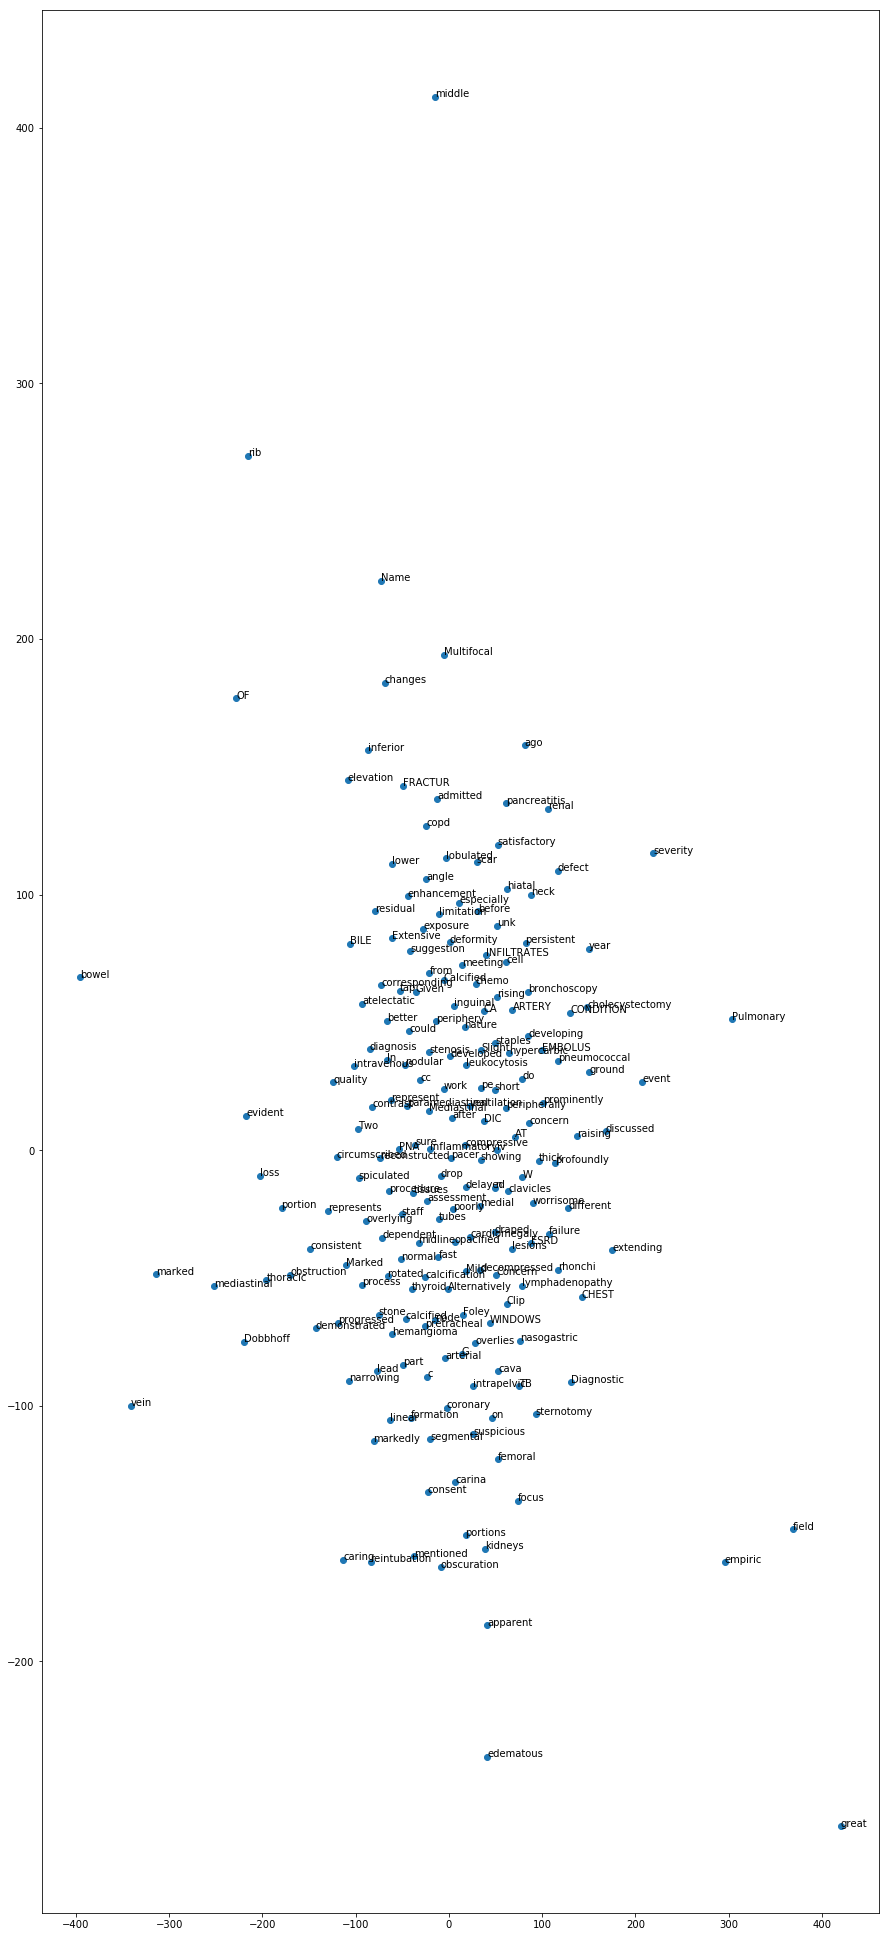

In [144]:
pneumonia_vocab = [k for (k, v) in pneumonia_model.wv.vocab.items()]
plot_embeddings(pneumonia_model, pneumonia_vocab[:200])

#### Visualize Partial Bigram Model

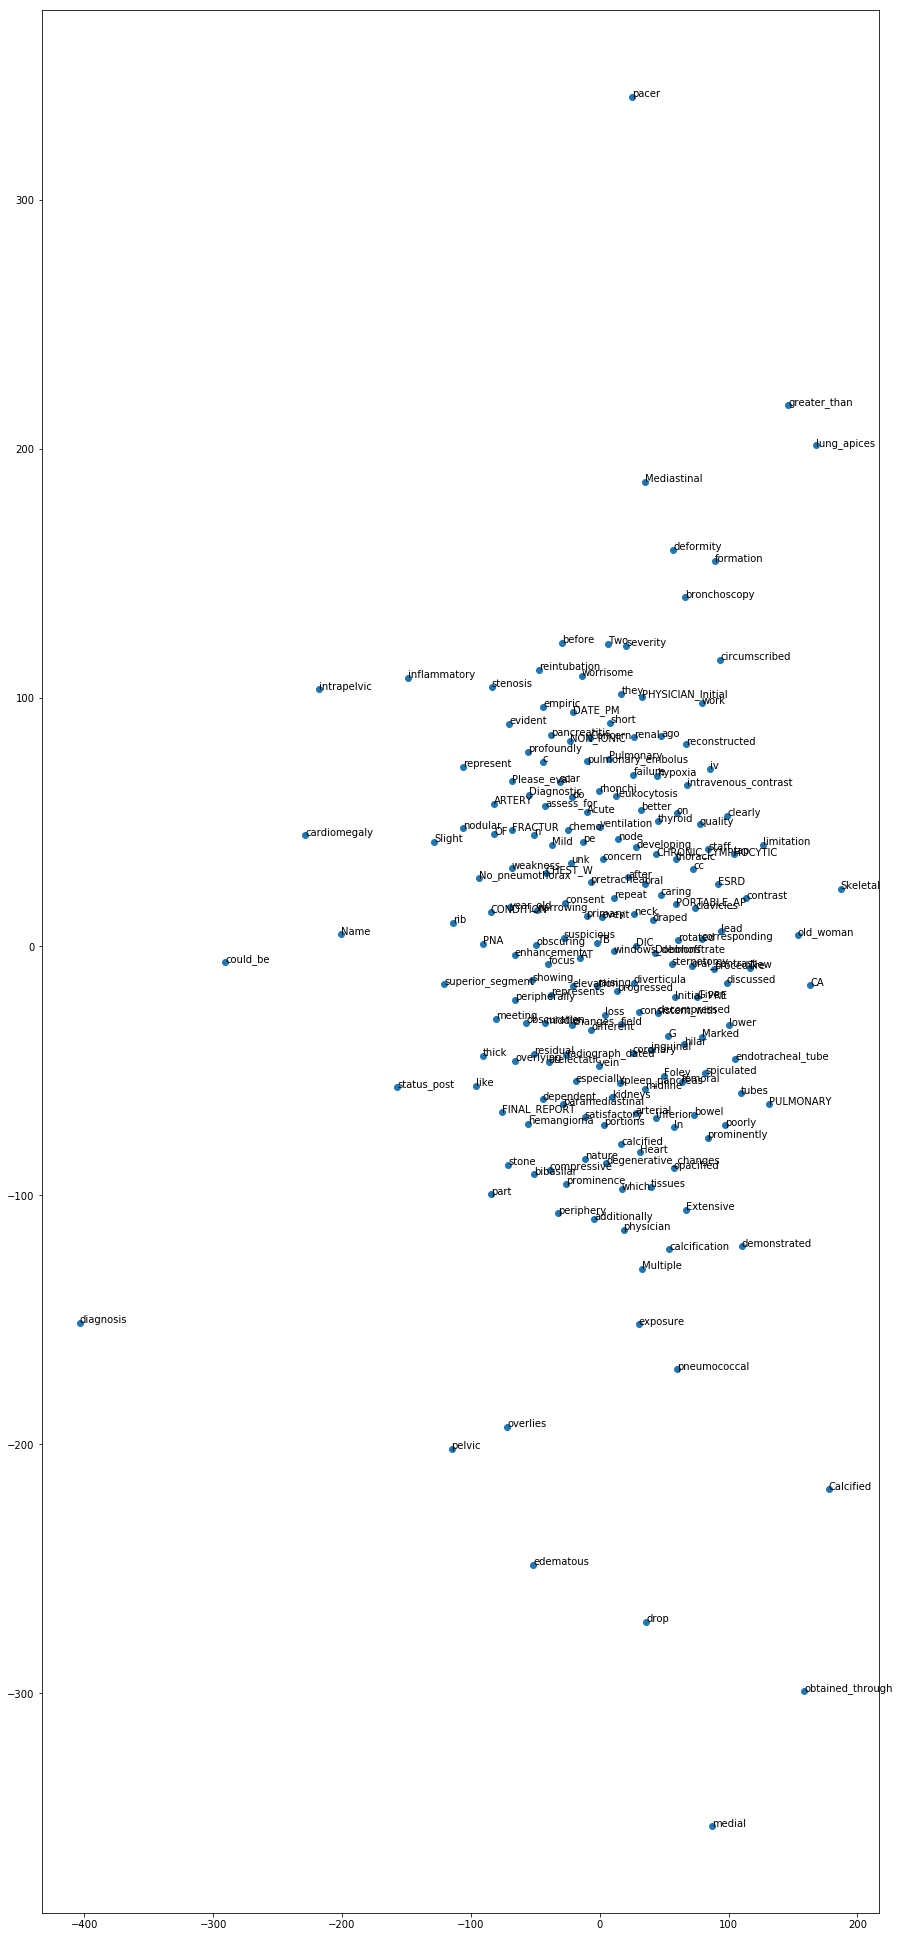

In [145]:
pneumonia_vocab = [k for (k, v) in pneumonia_bigram_model.wv.vocab.items()]
plot_embeddings(pneumonia_bigram_model, pneumonia_vocab[:200])